## Part2 - Logistic Regression

In [1]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#avoiding some warnings
np.seterr(all='ignore')

#data directory
path = './credit/'

#parameters to try
params = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])

In [2]:
#helper functions
def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [3]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_err = np.empty((5,5))
    ts_err = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        for param in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, param)
            tr_err[i,j] = error_rate(X_train, y_train, beta)
            ts_err[i,j] = error_rate(X_test, y_test, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    ts_mean = np.mean(ts_err, axis=0)
    return params[np.argmin(ts_mean)], tr_err, ts_err

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,params):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(params[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

def solve_logistic(algorithm, params, data_func=None):
    winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path+'credit-tr-{0}.npy'.format(i)
        ts_file = path+'credit-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        alpha,tr_err,ts_err = cross_alpha(X_tr, y_tr, algorithm, params)
        winners.append(alpha)
        beta,it = algorithm(X_tr, y_tr, alpha)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        print 'Best alpha: {0}'.format(alpha)
        fig = plt.figure()
        fig.set_figheight(7)
        fig.set_figwidth(13)
        fig.add_subplot(121)
        plt.boxplot(tr_err, showmeans=True, meanline=True)
        fig.add_subplot(122)
        plt.boxplot(ts_err, showmeans=True, meanline=True)
        plt.show()
        print 'Training error rate: {0}'.format(error_rate(X_tr,y_tr,beta))
        print 'Testing error rate: {0}'.format(error_rate(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    make_hist(winners,params)
    

### Mean functions

In [140]:
#Sigmoid function
def sigmoid(z):
    return 1./(1.+np.exp(-z))

#Overall cost function for logistic regression (log likelihood function)
def l(X, y, beta):
    y1_mask = y.astype(bool)
    y0_mask = np.logical_not(y1_mask)
    f = sigmoid(np.dot(X,beta))
    return (np.log(f[y1_mask])).sum() + (np.log(1-f[y0_mask])).sum()
    

#Error rate for logistic regression
def error_rate(X, y, beta):
    h = np.round(sigmoid(np.dot(X,beta)))
    h = h.astype(int)
    y = y.astype(int)
    m, = h.shape
    return np.logical_xor(h,y).sum()/np.float(m)

#Stochastic gradient ascent for logistic regression
def gd_stochastic(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in xrange(max_iter):
        l0 = l1
        for m in xrange(M):
            beta += alpha*(y[m]-sigmoid(np.dot(X[m],beta)))*X[m]
        l1 = l(X,y,beta)
        if np.abs(l1) < eps: break
    return (beta,i+1)

#Newton-Raphson method for logistic regression
def nr_logistic(X, y, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in xrange(max_iter):
        l0 = l1
        f = sigmoid(np.dot(X,beta))
        W = np.diag(f*(1-f))
        Hess = -1*np.dot(X.T, np.dot(W, X))
        Dl = np.dot(X.T, y-f)
        #when it converges, Hess became singular
        try:
            beta -= np.linalg.solve(Hess, Dl)
        except np.linalg.LinAlgError:
            break
        l1 = l(X, y, beta)
        if np.abs(l1) < eps: break
    return (beta,i+1)

In [135]:
#working array
wa = np.load(path+'credit-tr-1.npy')
#X = wa[:,:-1]
X = rescale(wa[:,:-1], 0., 1.)
#X = normalize(wa[:,:-1])
m,n = X.shape
X = np.concatenate((np.ones((m,1)),X),axis=1)
y = np.ascontiguousarray(wa[:,-1])

In [146]:
beta1,it = nr_logistic(X, y, 1.0)
print 'Beta:', beta1
print 'N° Iter:', it
print 'Error rate:', error_rate(X,y,beta1)

Beta: [  386.22218941  -134.63700429 -1311.72058215  -264.81627176  2719.35544532
  -839.27080576    47.22642184]
N° Iter: 21
Error rate: 0.0


In [139]:
beta2,it = gd_stochastic(X, y, 10)
print 'Beta:', beta2
print 'N° iter:', it
print 'Error rate:', error_rate(X,y,beta2)

Beta: [  219.09024529   -71.63364477  -789.74696886  -159.88784422  1690.73437923
  -518.06907211    26.54939681]
N° iter: 100000
Error rate: 0.0


## 1)

In [147]:
params1 = np.array([0.2,0.4,0.6,0.8,1.0])
params2 = np.linspace(1e-3, 1e-2, 5, endpoint=True)

### Newton-Raphson with raw data

###########################################################
Dataset: 0
Best alpha: 1.0


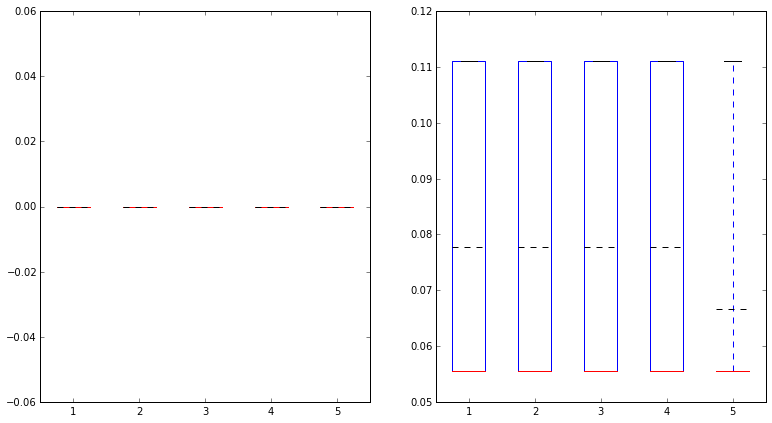

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 21
Beta: [ 801.76905186    7.08520207  -30.84059354   -1.26682125  332.45003298
 -857.53711237    1.58287241]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.2


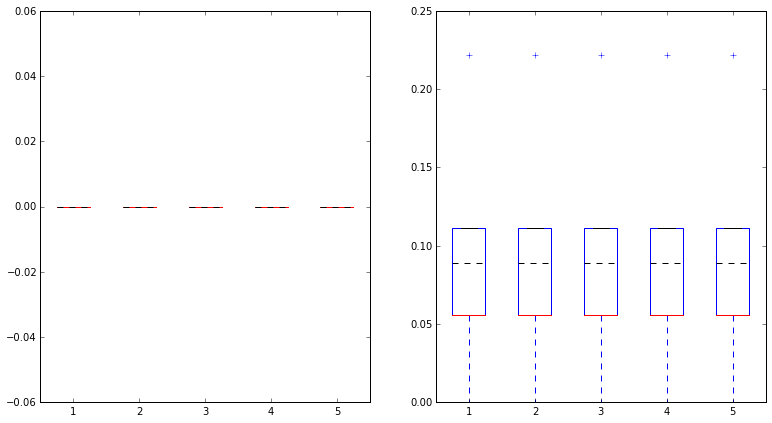

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 98
Beta: [ 1133.77867312    -3.71954809   -33.33015298    -1.25594062   335.92705293
  -829.36038411     2.05277711]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.2


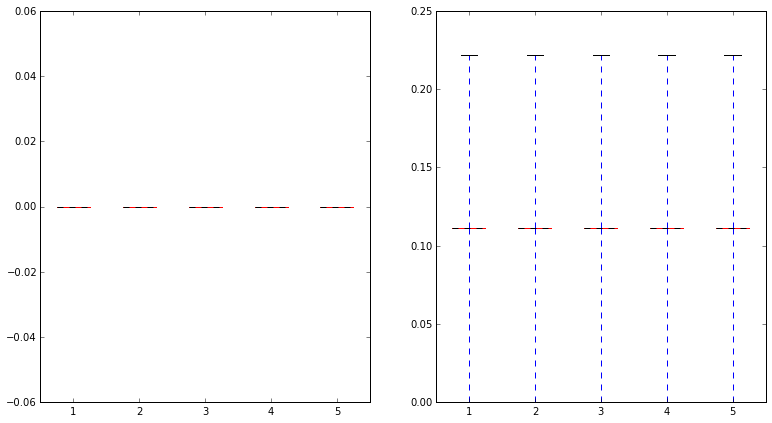

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 92
Beta: [ 432.7528628    -1.18396963   -9.87466609   -0.6545947   101.62283621
 -297.01969987   -3.37241181]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.2


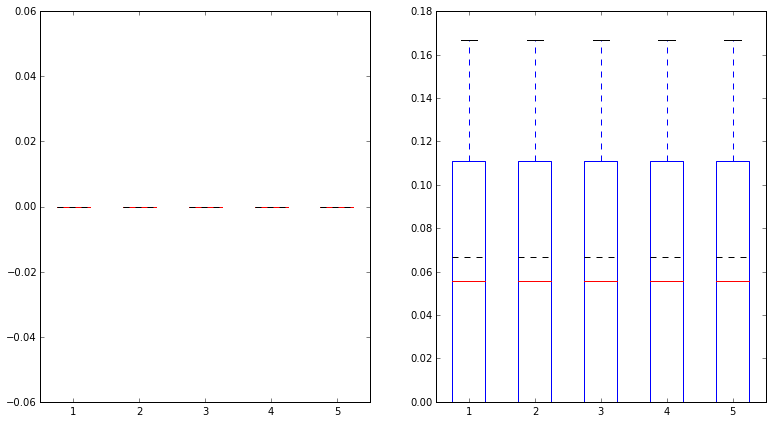

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 94
Beta: [ 317.80250697    1.72474958  -12.93753649   -0.3391333   132.78387852
 -321.56787374    2.2425915 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.2


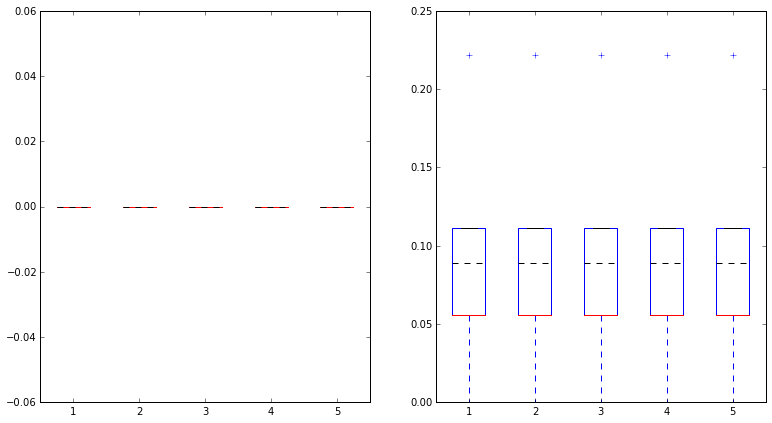

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 100
Beta: [ 1397.02521833     9.15934911   -42.09355278    -2.25835097   455.83933412
 -1108.27998538   -16.01121636]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.2


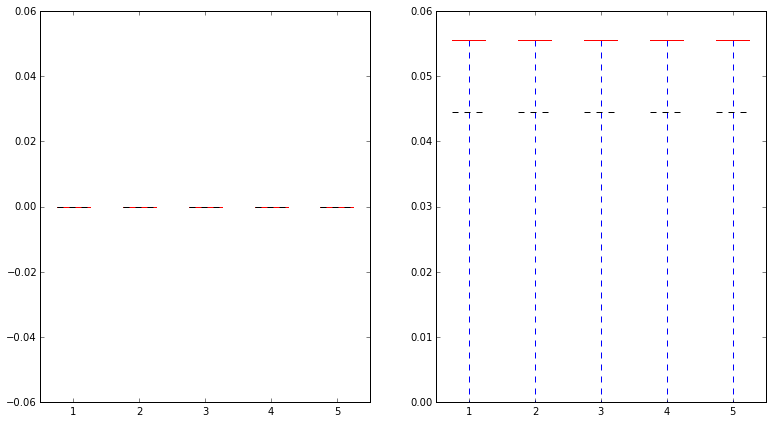

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 106
Beta: [ 4384.65287756    17.98784009  -143.70637446    -5.84531073  1412.6158585
 -3573.95725761    -7.48025182]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.2


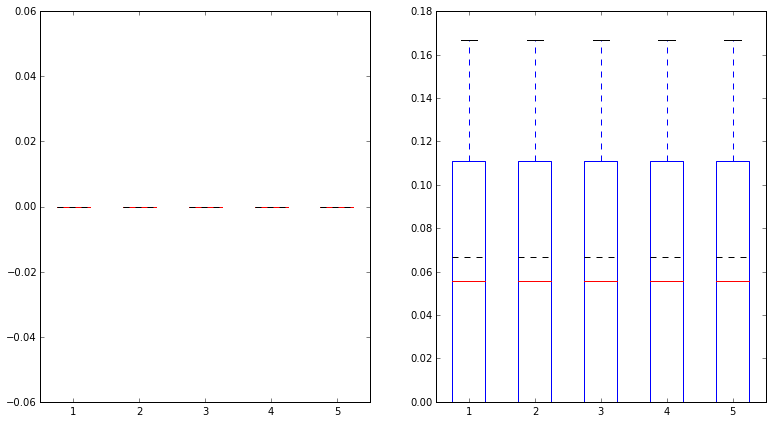

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 95
Beta: [  8.02749000e+02  -2.85393577e+00  -2.24002118e+01  -8.28612720e-01
   1.81609705e+02  -4.41035636e+02   7.67654920e-03]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.2


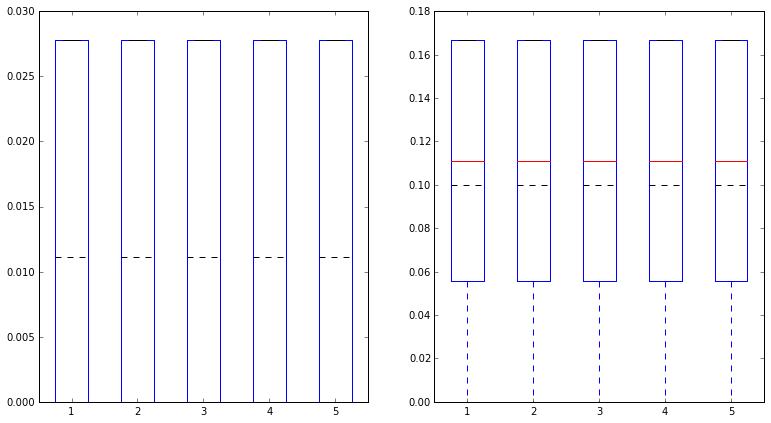

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 100000
Beta: [  1.35700989e+02   8.90540535e-01  -4.87957578e+00  -1.94248638e-01
   5.94531064e+01  -1.53417253e+02  -6.49440579e-02]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.2


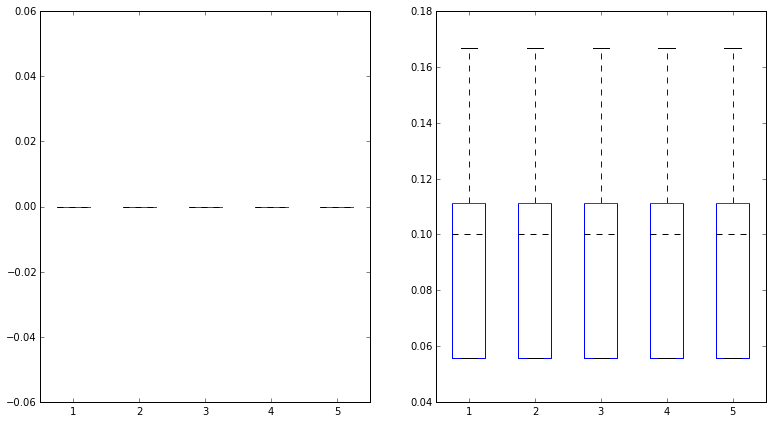

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 97
Beta: [  9.61887734e+02   4.31038788e-02  -3.06994970e+01  -1.30182851e+00
   2.71252453e+02  -6.57098324e+02   1.82342588e+00]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.6


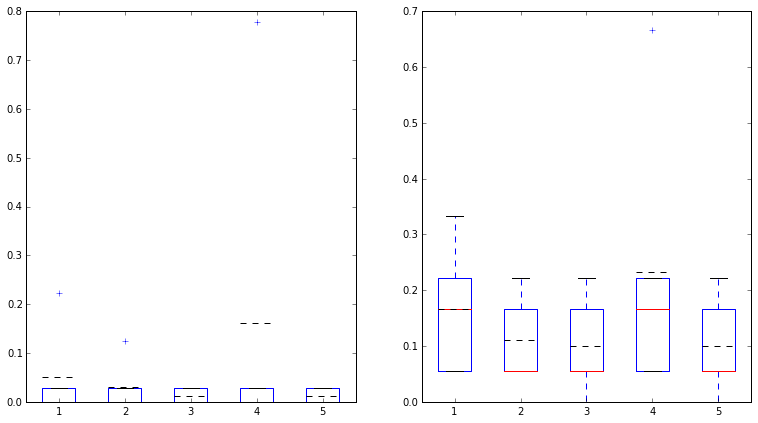

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 76
Beta: [ 333.44349066    1.74720328  -11.34495993   -0.47250119  132.29818204
 -337.56787276   -0.7495022 ]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.2


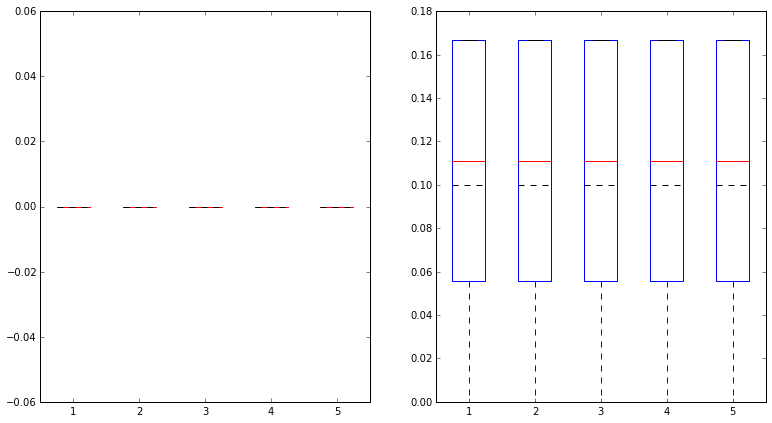

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 97
Beta: [ 888.72024815    4.47018422  -26.98282891   -1.35880532  275.2290152
 -653.93076892   -7.67298756]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.2


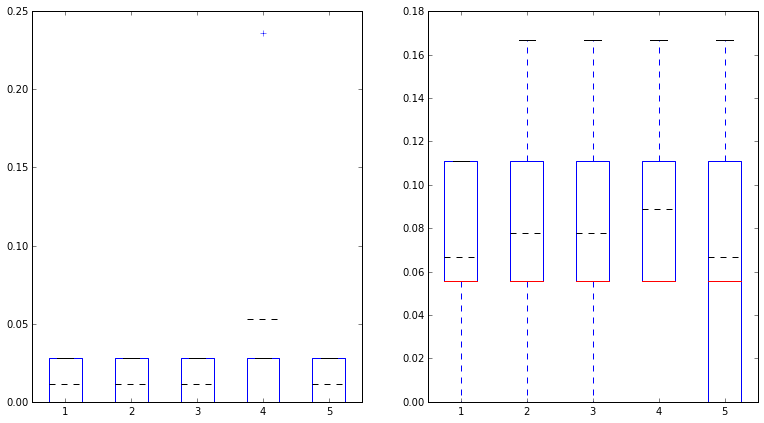

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 217
Beta: [ 339.262849      1.74424248  -11.32371983   -0.47161675  131.70006651
 -342.33741555   -0.74804431]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.2


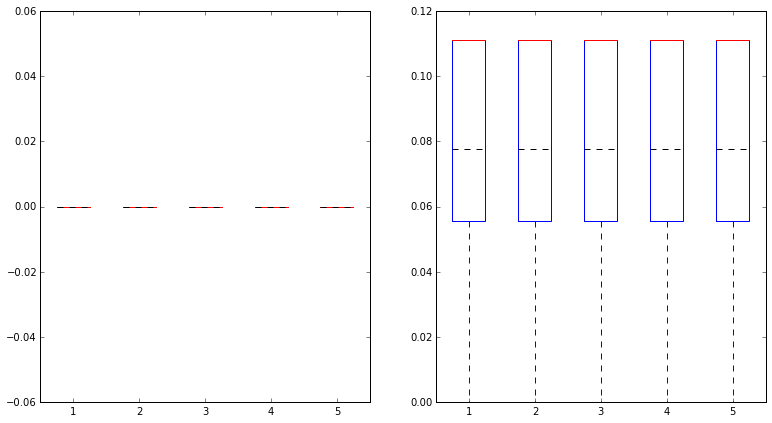

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 101
Beta: [ 1689.10574927    10.40883769   -51.19335886    -2.73906921   538.41964423
 -1300.00392446   -17.2658916 ]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.2


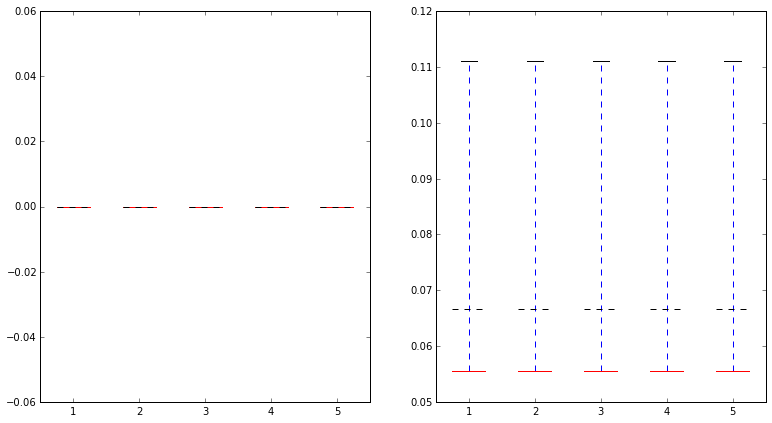

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 107
Beta: [ 9053.38570034   -60.04846597  -219.72261609    -9.8154918   1410.78796505
 -3254.67460945   -10.87682624]
###########################################################


###########################################################
Dataset: 14
Best alpha: 1.0


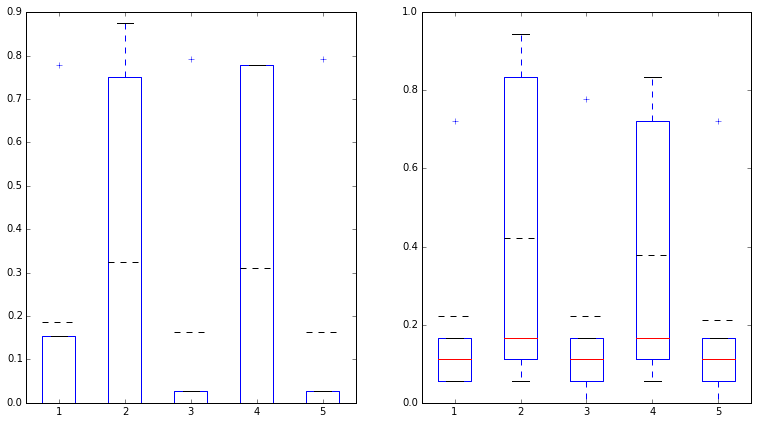

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 42
Beta: [ 333.44349066    1.74720328  -11.34495993   -0.47250119  131.59783877
 -335.46684295   -0.7495022 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.2


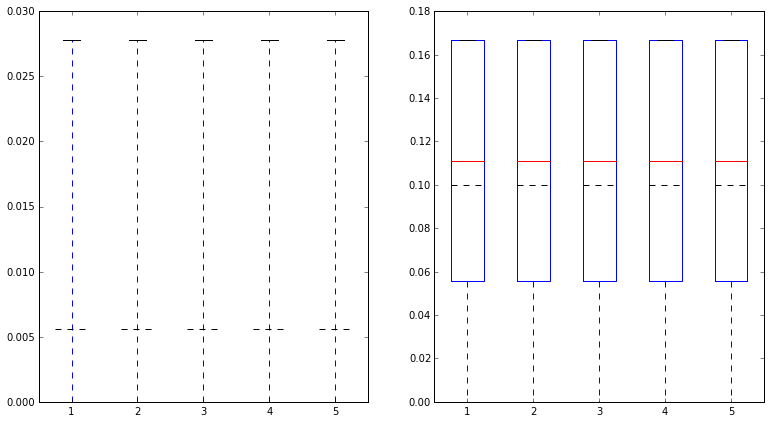

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 197
Beta: [ 360.40255443    1.7442343   -11.32366332   -0.47161439  131.15765626
 -361.85187213   -0.74803991]
###########################################################


###########################################################
Dataset: 16
Best alpha: 1.0


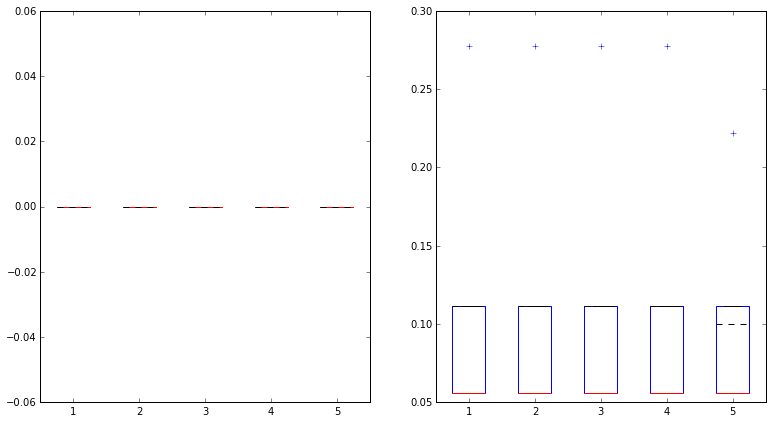

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 20
Beta: [ 502.75858454    3.38561512  -13.91335666   -0.96227088  140.96090842
 -310.64468185   -7.2485097 ]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.2


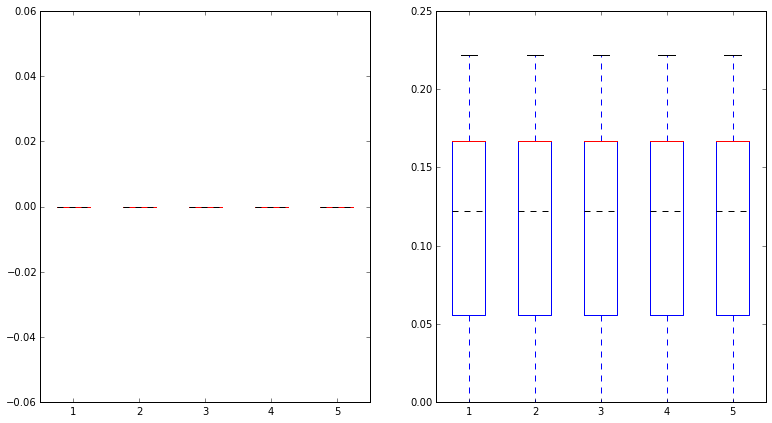

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 100
Beta: [ 1685.49765221    10.35793292   -50.92718252    -2.72538794   470.45863507
 -1102.65760889   -17.19515579]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.2


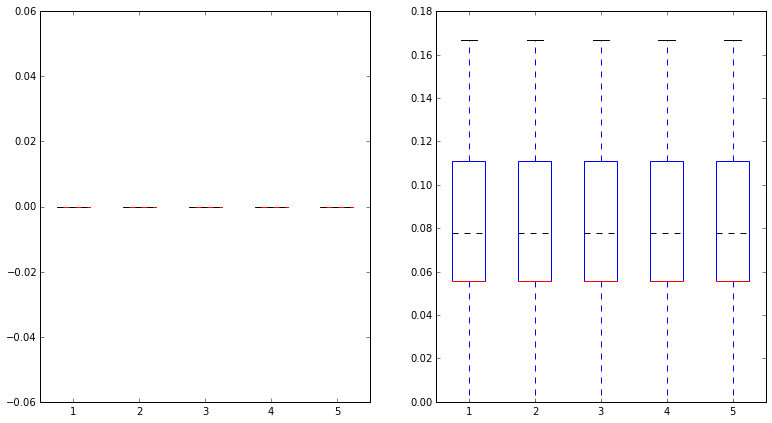

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 101
Beta: [ 1245.06082499     8.84081946   -40.08231404    -1.74256062   477.47507117
 -1185.02036141   -15.4608018 ]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.2


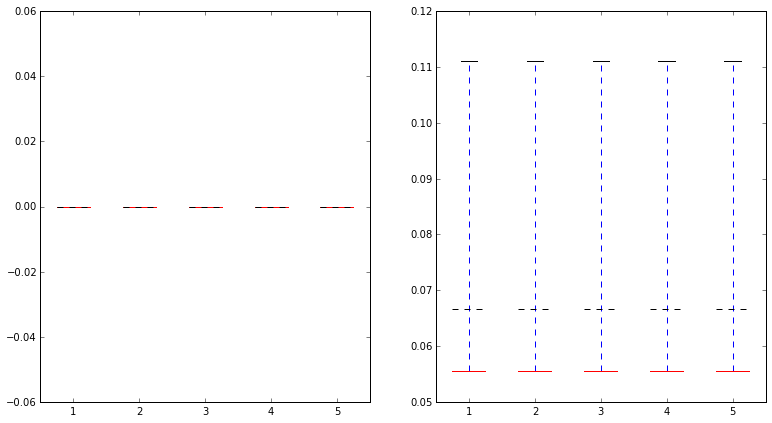

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 97
Beta: [ 937.63561572    0.94513214  -30.59707731   -1.29248088  259.6946788
 -625.21892347    1.78493656]
###########################################################




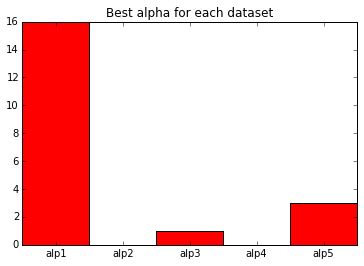

In [148]:
solve_logistic(nr_logistic, params1)

### Newton-Raphson with rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.2


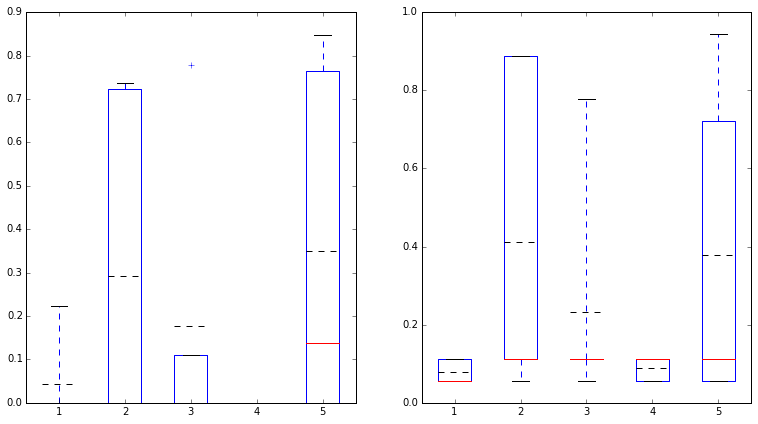

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 306
Beta: [  403.17533722   820.96644589 -4042.53731287  -909.2673169   9013.72824914
 -2890.82982924   119.23537701]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.2


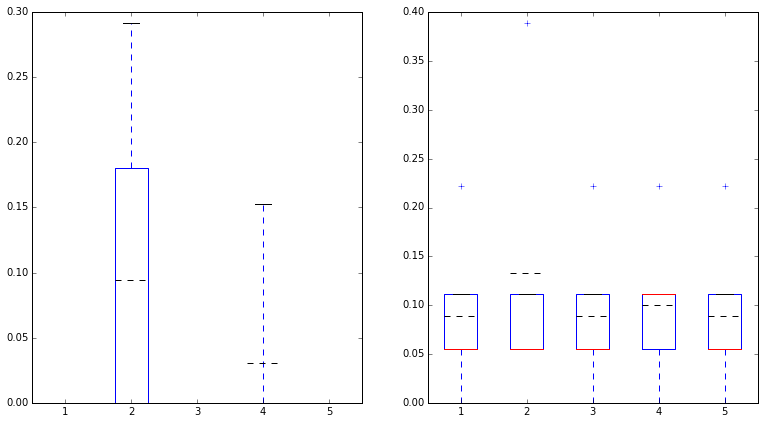

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 324
Beta: [ 1368.12235724  -493.17224455 -4650.84991261  -937.58950021  9608.21424165
 -2963.62442416   174.00060381]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.2


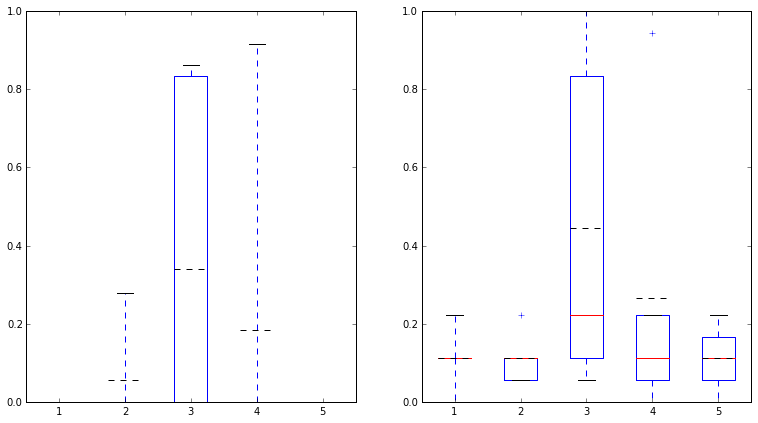

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 225
Beta: [  511.30766707  -132.13826935 -1115.7161734   -385.5482107   2079.42654945
  -859.68271936  -213.19909913]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.4


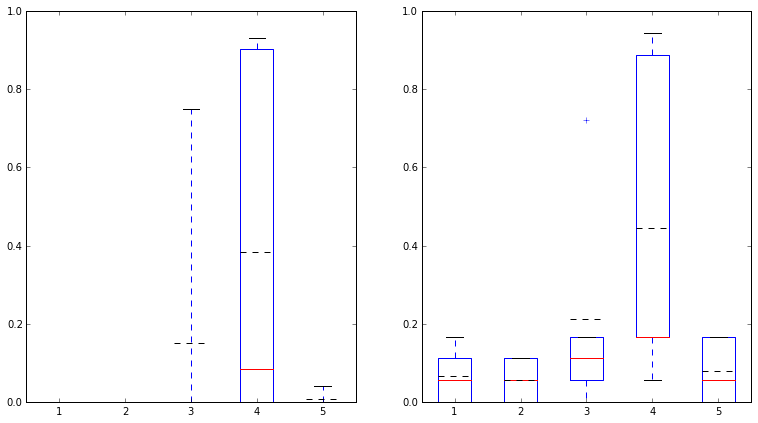

Training error rate: 0.1
Testing error rate: 0.166666666667
N° iterations: 105
Beta: [ -1.57035286e+29   3.96672376e+31  -9.27562194e+31  -2.37402222e+31
   2.48967772e+46  -9.33629145e+45  -8.11296384e+30]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.6


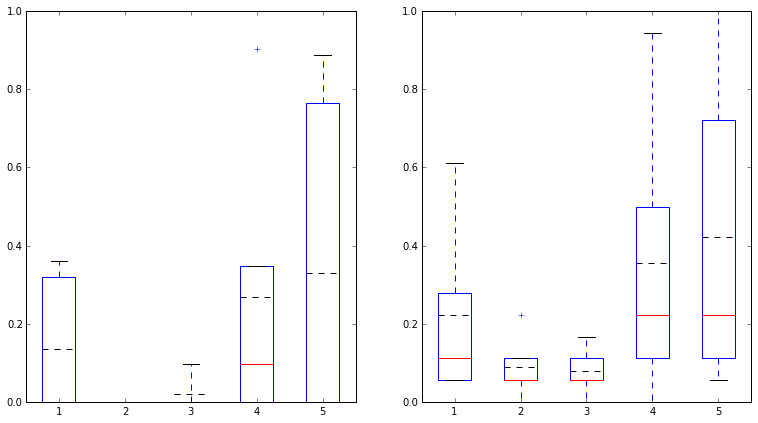

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 74
Beta: [   874.28761684    955.1803553   -4678.56727714  -1352.57682369
  10278.28262432  -3112.85045345   -952.99561226]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.4


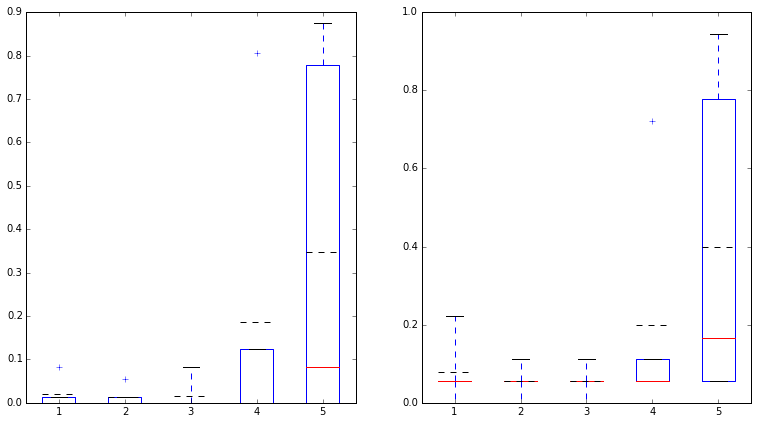

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 123
Beta: [  3121.32974545   1939.88387458 -16715.2552242   -3650.177319
  33635.54620703 -10646.86146648   -515.69312123]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.4


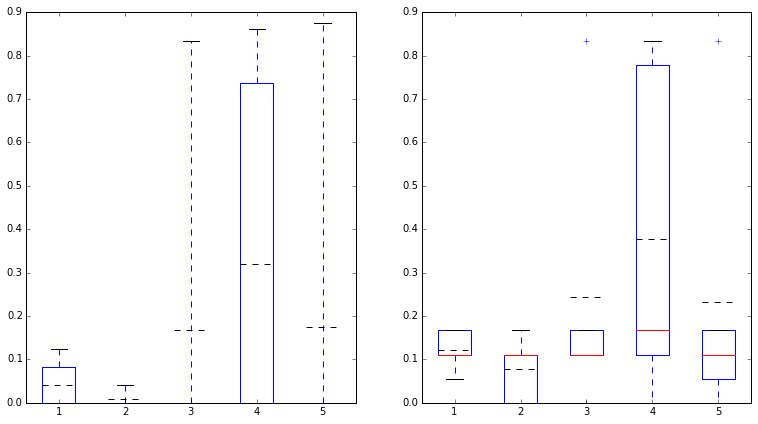

Training error rate: 0.422222222222
Testing error rate: 0.433333333333
N° iterations: 104
Beta: [ -2.77145831e+40  -1.30191434e+40   1.26358761e+41   3.00151296e+40
   3.71592495e+40  -3.09289170e+40  -4.15087276e+38]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.6


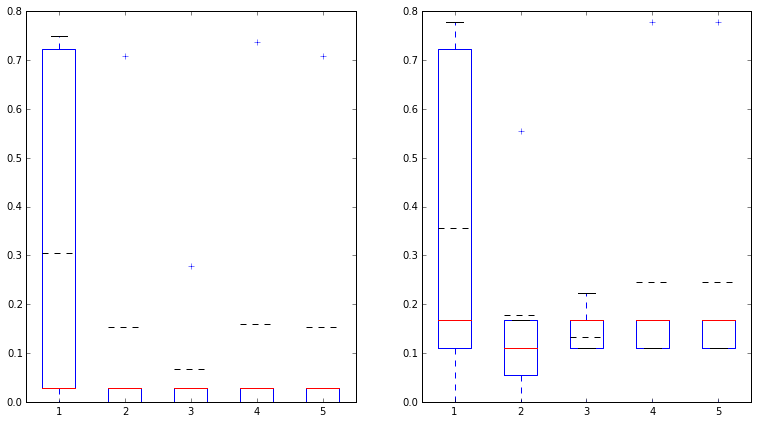

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 24
Beta: [  23.05059358   33.0689502  -189.61661265  -40.53395643  439.42826807
 -139.8762308    -1.39994843]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.2


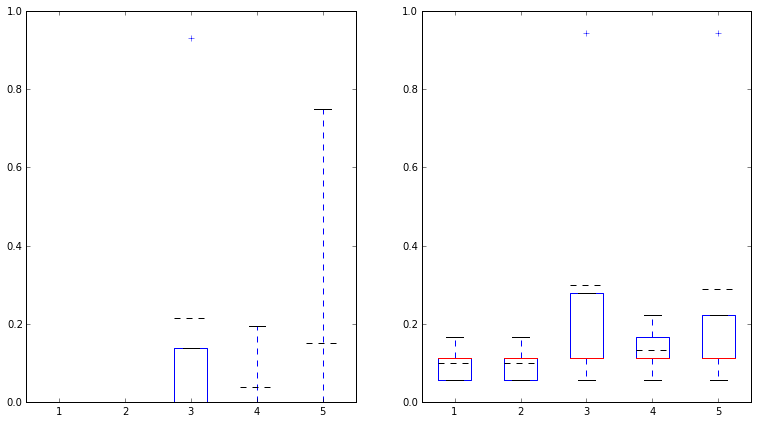

Training error rate: 0.944444444444
Testing error rate: 0.933333333333
N° iterations: 202
Beta: [ -8.13734170e+15  -9.68815889e+14   3.98262971e+16   8.76511885e+15
  -5.09709947e+16   1.65705267e+16  -1.91214795e+15]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.6


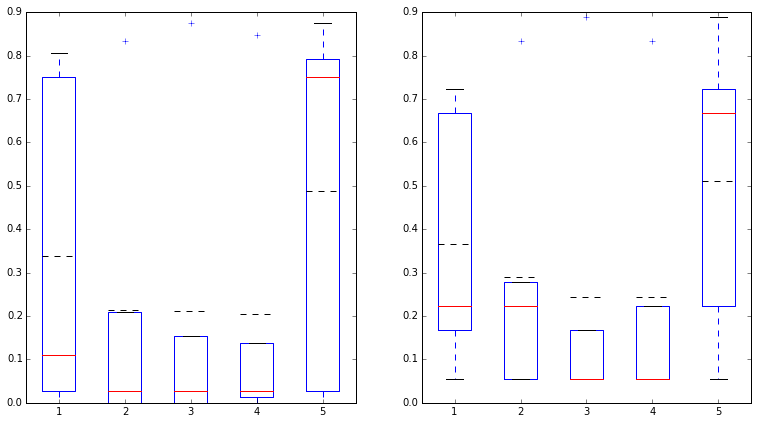

Training error rate: 0.133333333333
Testing error rate: 0.333333333333
N° iterations: 68
Beta: [ -2.75602802e+02   1.22294210e+04  -8.42815122e+04  -1.91697583e+04
   5.51240451e+17  -2.06715169e+17  -4.51391668e+03]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.6


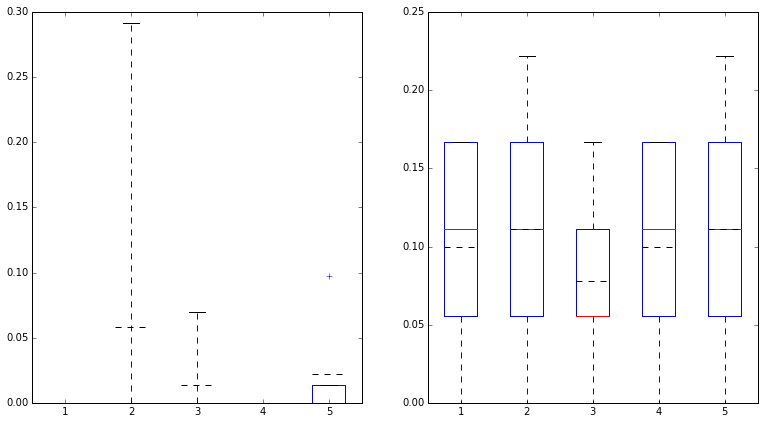

Training error rate: 0.733333333333
Testing error rate: 0.9
N° iterations: 70
Beta: [  5.31213725e+02   4.26657108e+02  -2.69686307e+03  -7.25991907e+02
  -3.41567293e+14   1.46385983e+14  -4.62262281e+02]
###########################################################


###########################################################
Dataset: 11
Best alpha: 1.0


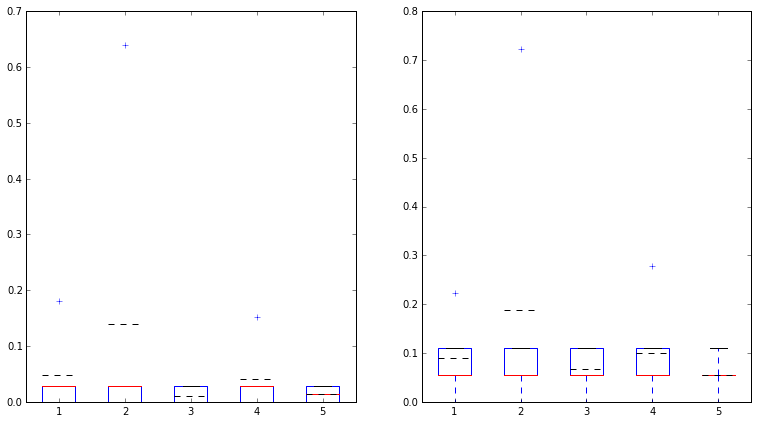

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 16
Beta: [  72.54940286   64.84160581 -440.58204416  -98.54777607  957.10260405
 -306.68916908  -16.21455461]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.6


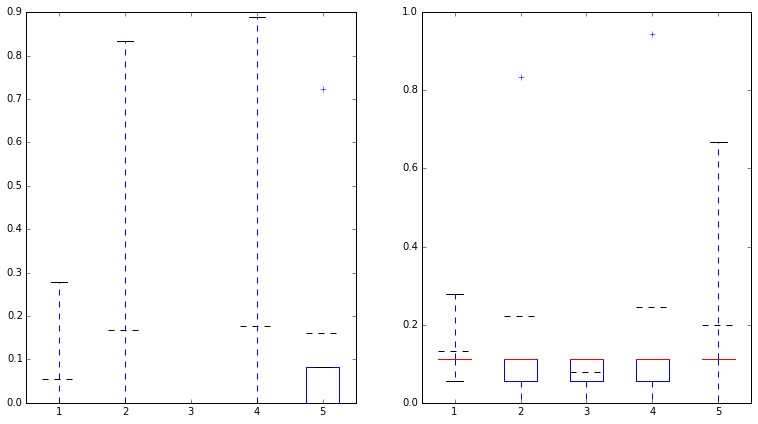

Training error rate: 0.277777777778
Testing error rate: 0.3
N° iterations: 66
Beta: [ -3.60594331e+13   9.00860463e+02  -4.63084087e+03  -1.33266379e+03
   9.99510622e+03   3.60594331e+13  -8.75620746e+02]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.8


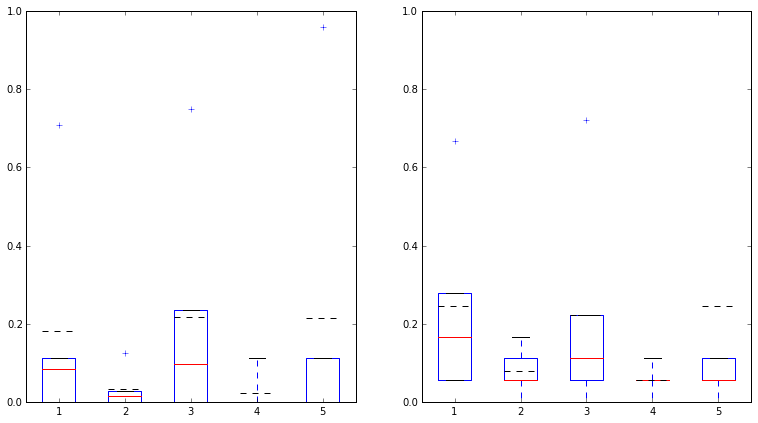

Training error rate: 0.144444444444
Testing error rate: 0.1
N° iterations: 17
Beta: [ -4.62919722e+18   4.98020047e+18  -1.56719220e+19  -3.52957874e+18
   4.12375442e+19  -8.15442266e+18  -8.71048641e+17]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.8


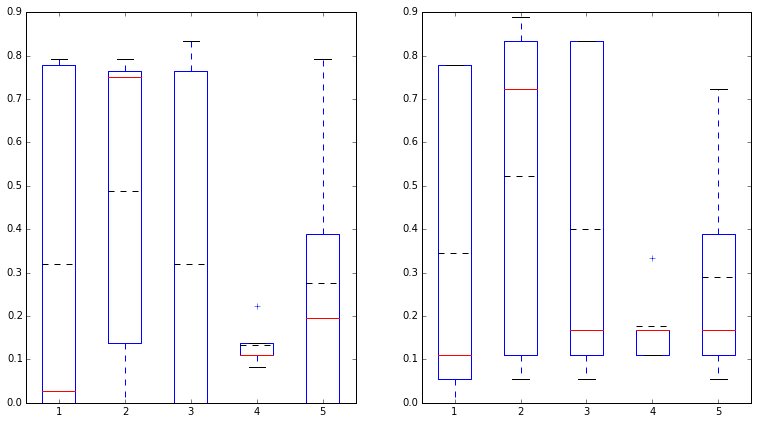

Training error rate: 0.788888888889
Testing error rate: 0.566666666667
N° iterations: 57
Beta: [  1.96382055e+05   1.18958614e+05  -8.89383825e+05  -1.99386501e+05
  -2.43394616e+17   9.12729809e+16  -3.77438072e+04]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.2


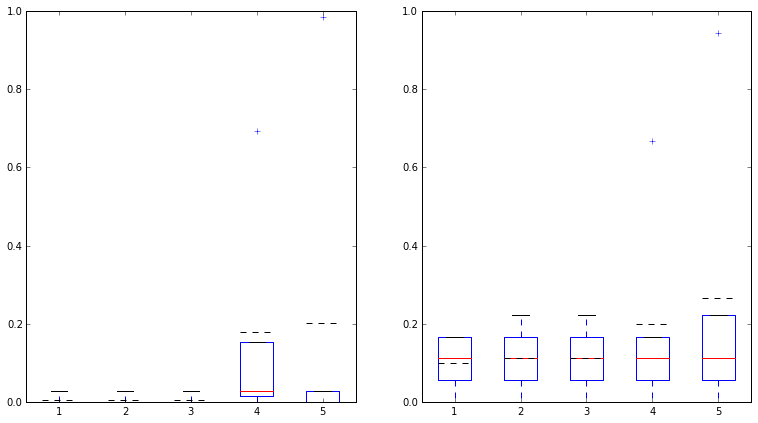

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 70
Beta: [  68.02194047   64.34511143 -425.57134887  -97.73027239  942.50877792
 -297.75309867  -14.36196829]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.4


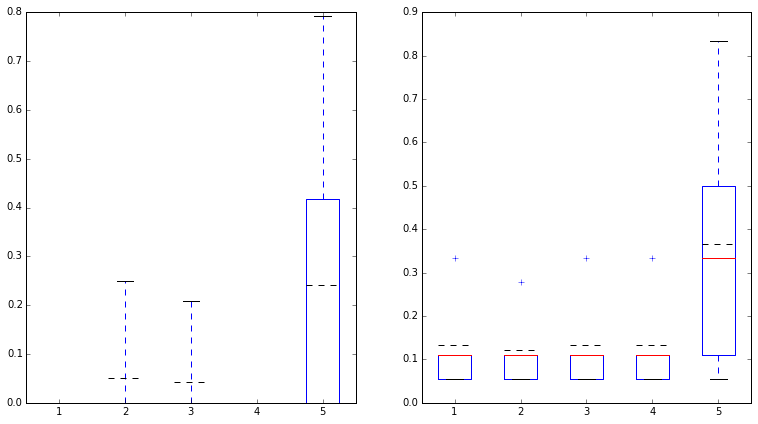

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 123
Beta: [  328.02015068   371.15795255 -1533.66017163  -578.03959615  3255.8185186
  -897.39047035  -489.44739504]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.8


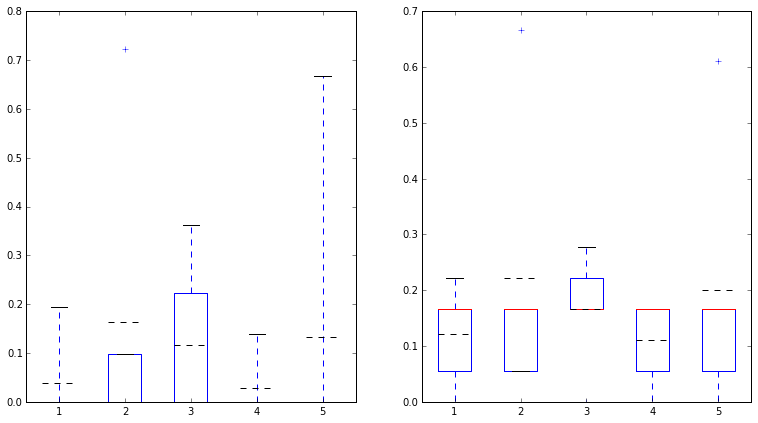

Training error rate: 0.911111111111
Testing error rate: 0.733333333333
N° iterations: 52
Beta: [ -2.37438205e+41  -9.05630048e+28   4.51261867e+29   1.36691938e+29
  -8.80933445e+29   2.37438205e+41   9.21927709e+28]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.2


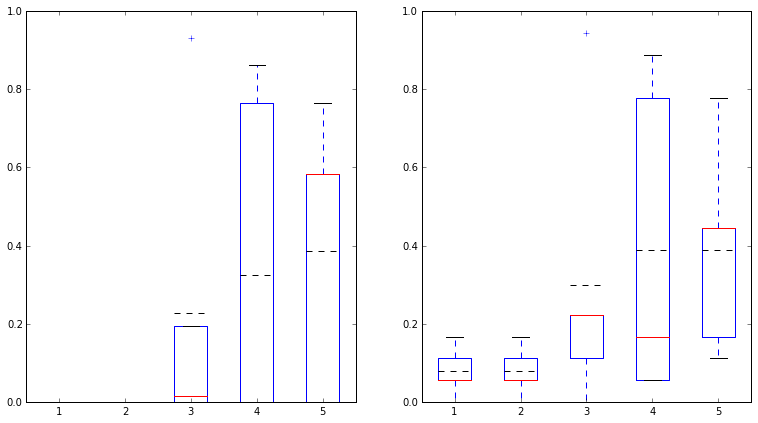

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 224
Beta: [   554.59164122    874.96986471  -4353.20082791  -1022.94638004
  10565.64911993  -3271.59931233   -989.9647166 ]
###########################################################


###########################################################
Dataset: 19
Best alpha: 1.0


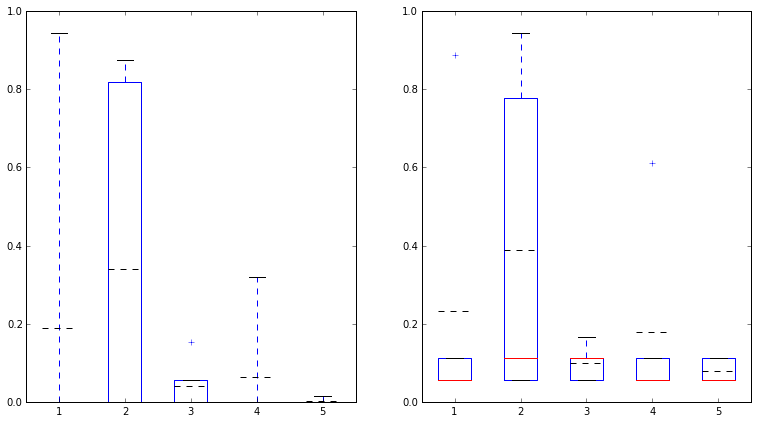

Training error rate: 0.855555555556
Testing error rate: 0.766666666667
N° iterations: 43
Beta: [ -1.43882276e+19   2.27702581e+19  -1.80704305e+18   3.11197634e+17
  -2.53530120e+30   1.08655766e+30  -4.44988616e+17]
###########################################################




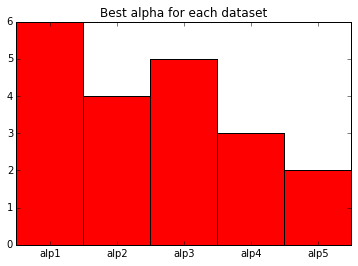

In [26]:
solve_logistic(nr_logistic, params1, rescale)

### Newton-Raphson with normalized data

###########################################################
Dataset: 0
Best alpha: 0.2


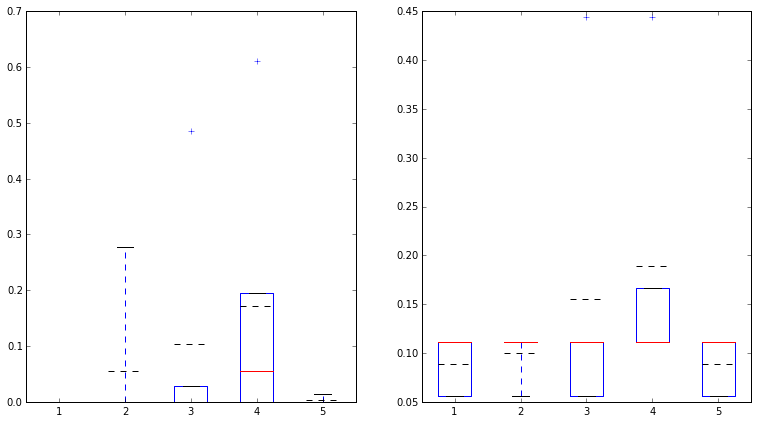

Training error rate: 0.0
Testing error rate: 0.0333333333333
N° iterations: 260
Beta: [  -60.14111749   210.91643787  -995.83336414  -323.98326533  1944.18606247
 -1254.46881236    25.67057134]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.2


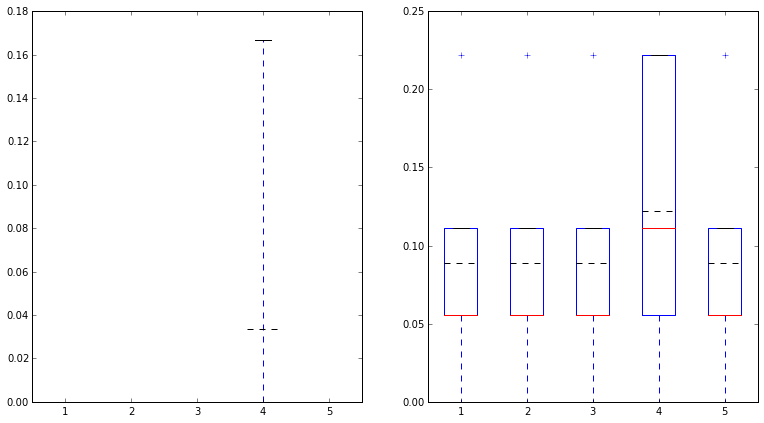

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 285
Beta: [  -42.80901837  -129.95201628 -1205.71573278  -349.37134083  2074.0937013
 -1337.16263784    34.93461495]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.6


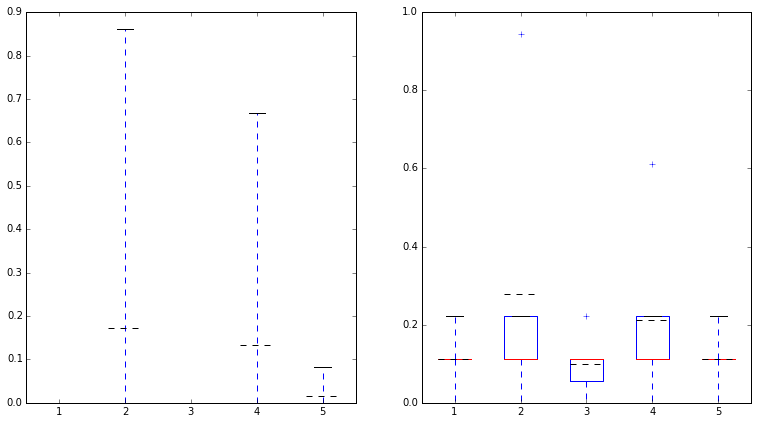

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 94
Beta: [ -42.6398427   -42.84129428 -342.14543184 -168.71918884  625.34724423
 -481.48139903  -50.25590159]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.6


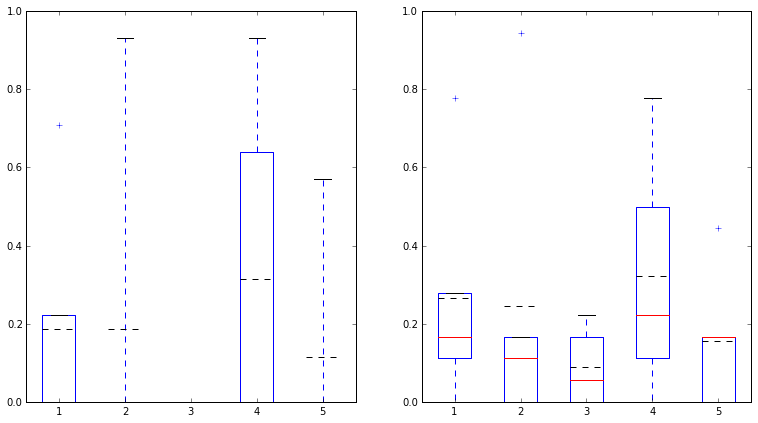

Training error rate: 0.0
Testing error rate: 0.0666666666667
N° iterations: 124
Beta: [   4.36463668   65.10222628 -517.91559563 -114.38409119  998.56879844
 -589.54871087   35.28941142]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.2


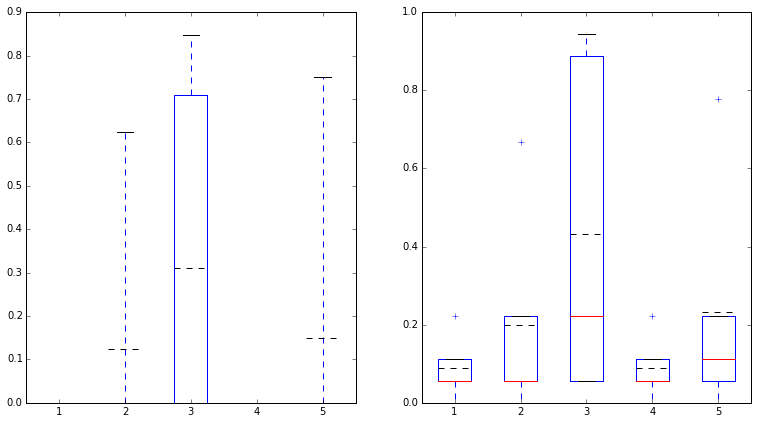

Training error rate: 0.0
Testing error rate: 0.166666666667
N° iterations: 234
Beta: [ -433.52931172   271.9301953  -1291.1347422   -570.52546171  2568.90930335
 -1469.17296951  -219.05165906]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.6


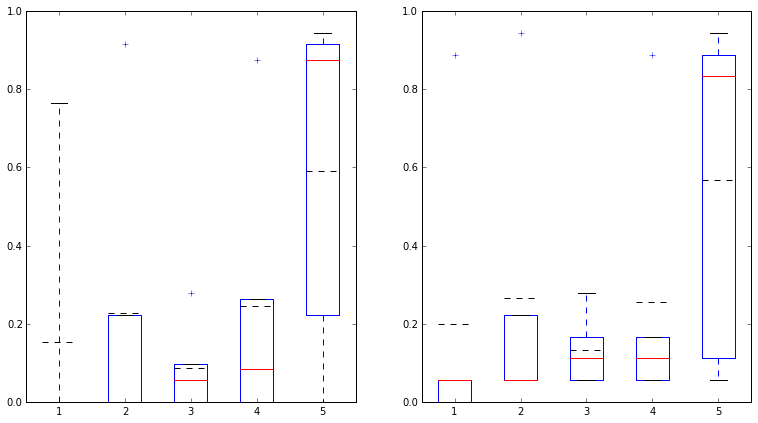

Training error rate: 0.0777777777778
Testing error rate: 0.133333333333
N° iterations: 72
Beta: [  2.51848847e+29   1.03203056e+17  -8.57785898e+17  -2.98654118e+17
   1.05222271e+30  -8.19210724e+29  -2.24860225e+16]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.6


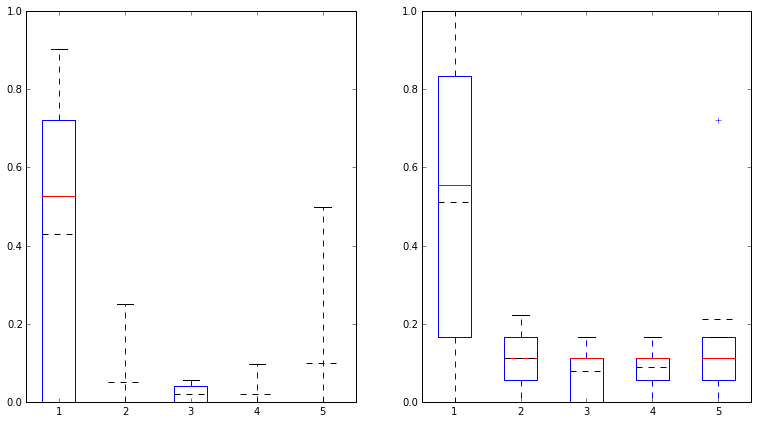

Training error rate: 0.388888888889
Testing error rate: 0.5
N° iterations: 101
Beta: [  1.74672409e+26   1.18026073e+26  -3.47775473e+26   8.36594763e+25
   2.90131401e+26  -2.79082871e+26  -6.27877655e+26]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.2


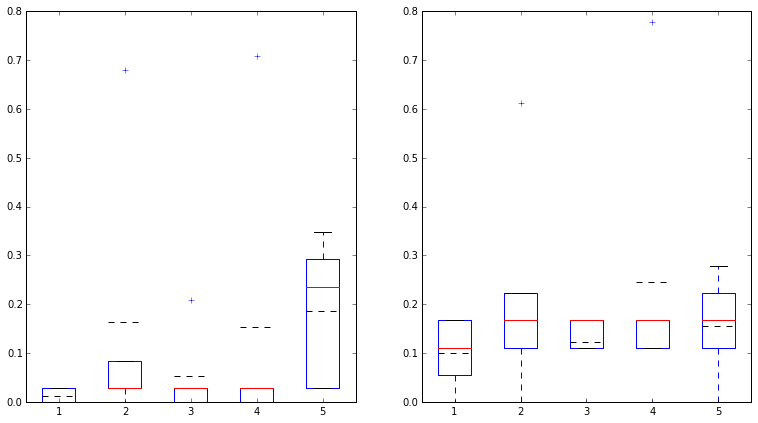

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 67
Beta: [  -6.74149961    9.27585304  -52.71052459  -16.58532723  102.25711105
  -66.92244913   -0.30369144]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.2


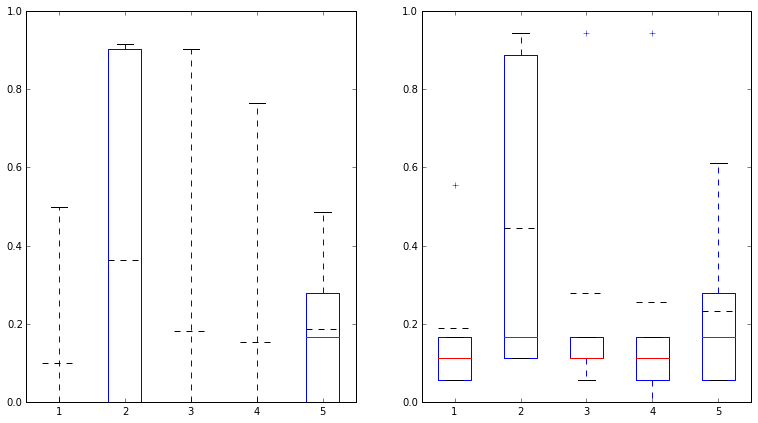

Training error rate: 0.0666666666667
Testing error rate: 0.0666666666667
N° iterations: 223
Beta: [ -1.51380877e+26  -1.52089068e+27  -8.57565589e+27  -2.99475370e+27
   1.00417080e+28  -6.08338731e+27   1.64718150e+26]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.4


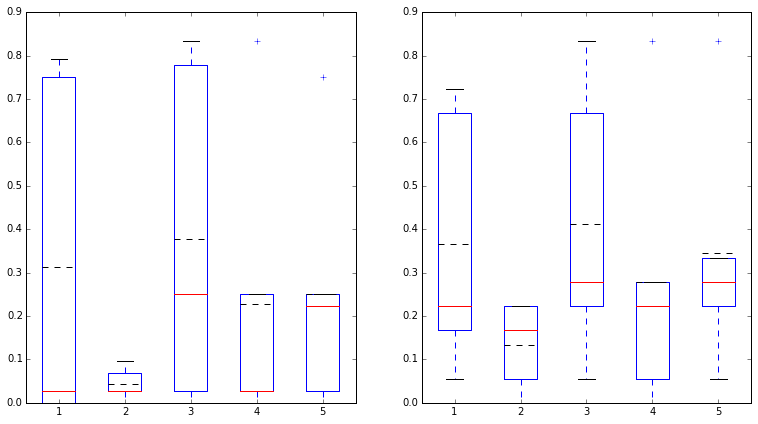

Training error rate: 0.844444444444
Testing error rate: 0.866666666667
N° iterations: 110
Beta: [ -1.29477667e+21   6.69349076e+20   5.00600126e+19   7.45498629e+19
  -4.78835096e+21   2.79715029e+21   2.57512494e+19]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.2


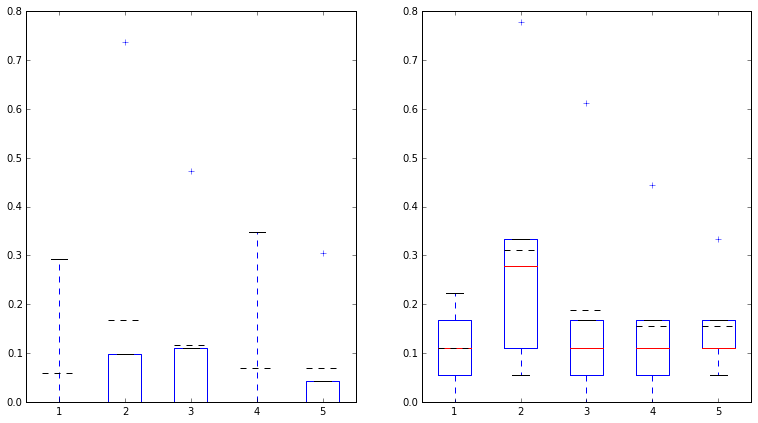

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 346
Beta: [ -137.62166984   171.14019211 -1074.43374367  -446.00940624  1928.00248824
 -1180.98206299  -138.83050789]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.6


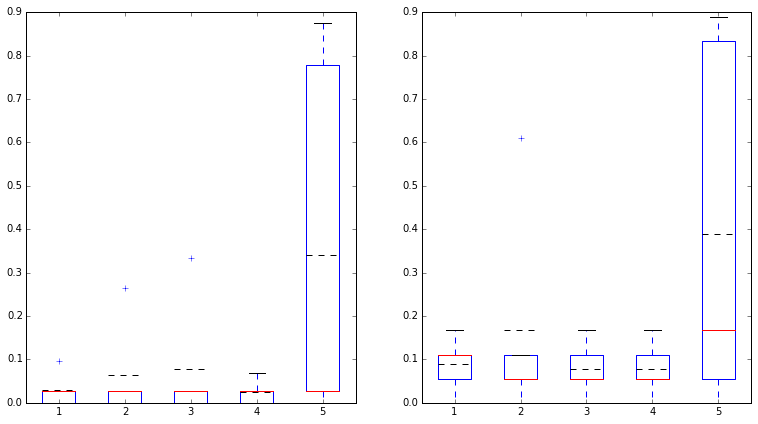

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 25
Beta: [ -25.09230904   18.46002464 -121.48761209  -38.64568691  205.13426166
 -147.95097367   -3.73099628]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.2


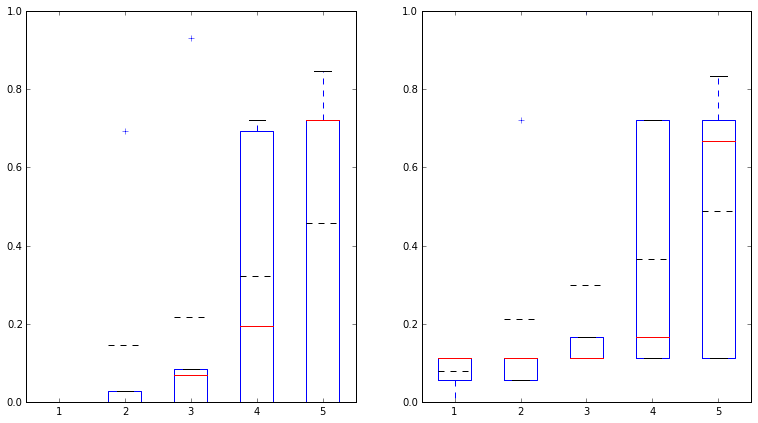

Training error rate: 0.922222222222
Testing error rate: 0.733333333333
N° iterations: 197
Beta: [ -2.43120385e+42  -2.45921814e+29   1.27409267e+30   5.64538432e+29
  -2.42039603e+30   3.27310835e+42   2.06891725e+29]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.2


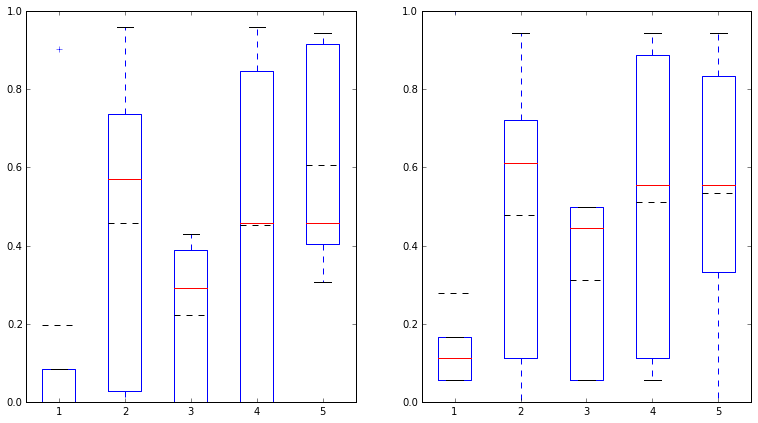

Training error rate: 0.0
Testing error rate: 0.133333333333
N° iterations: 209
Beta: [ -865.77539564 -1525.89481516 -5925.05741319 -2155.1086108   6521.49412554
 -4052.32268649  -143.88882892]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.6


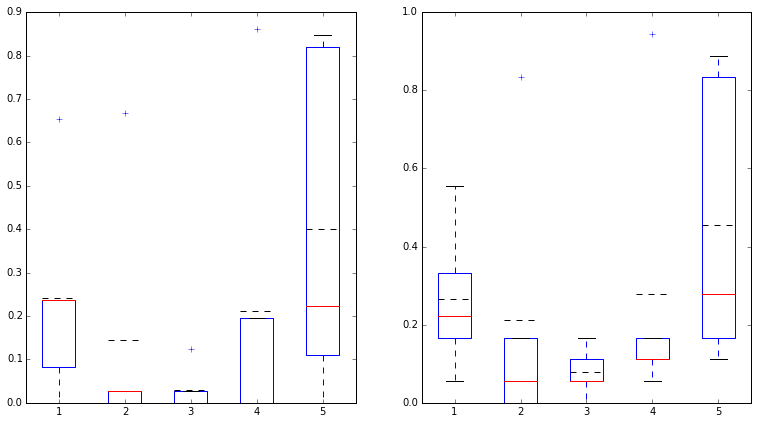

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 69
Beta: [  16.96227501   18.18216981 -124.95847509  -40.73476592  262.3598964
 -165.46726821   -3.77485352]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.6


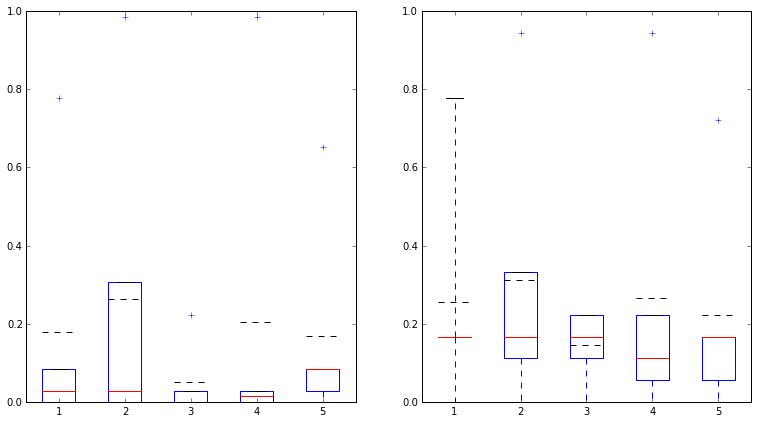

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 25
Beta: [  -1.74335987   17.84144914 -118.43731658  -41.10808597  218.58570218
 -148.04563625   -3.49285296]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.2


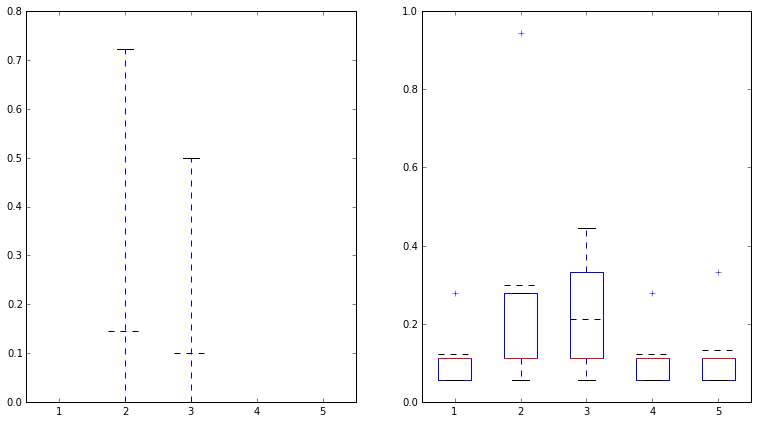

Training error rate: 0.0
Testing error rate: 0.2
N° iterations: 218
Beta: [   8.65008245   92.12626372 -373.64109105 -221.1702541   750.04693164
 -396.01611494 -102.25811851]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.2


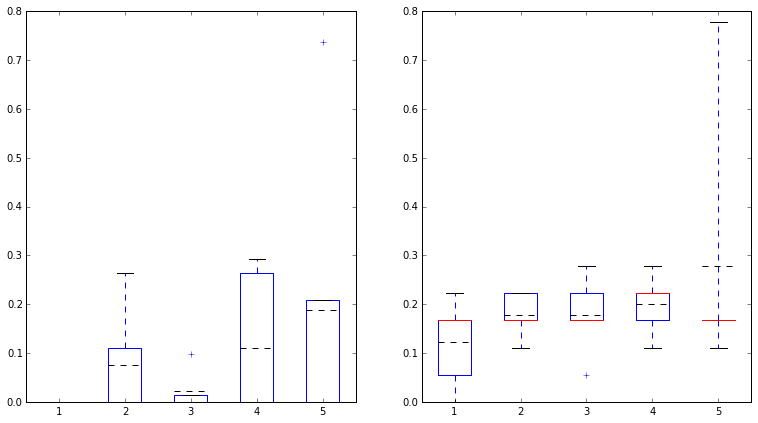

Training error rate: 0.911111111111
Testing error rate: 0.733333333333
N° iterations: 199
Beta: [ -5.56370127e+42  -1.32346168e+29   6.59239789e+29   3.00352842e+29
  -1.14582378e+30   7.67554040e+42   1.18563962e+29]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.2


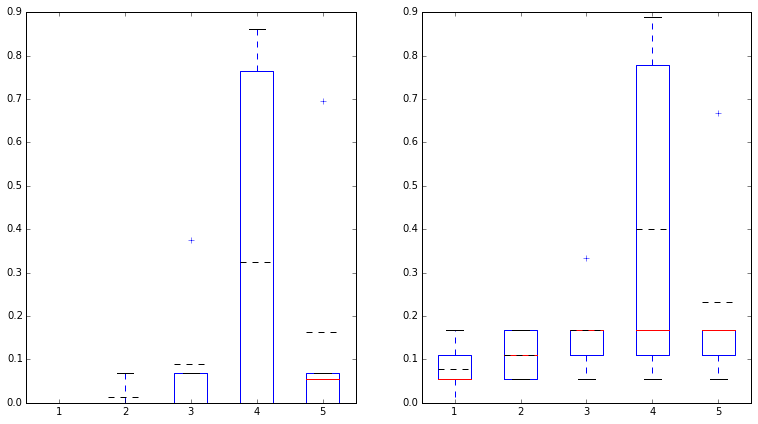

Training error rate: 0.777777777778
Testing error rate: 0.8
N° iterations: 205
Beta: [ -5.79597525e+43   3.31140992e+30  -1.71173985e+31  -6.11268280e+30
  -1.36031432e+44   1.03601057e+44  -2.84108169e+30]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.6


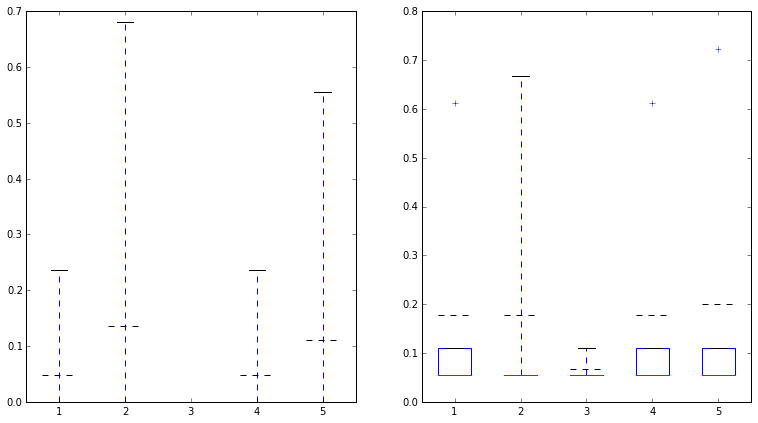

Training error rate: 0.766666666667
Testing error rate: 0.7
N° iterations: 71
Beta: [  3.61265136e+17   1.73692100e+14   6.86958778e+17   2.52165849e+17
  -1.60878823e+17  -4.84950962e+16  -1.03967275e+16]
###########################################################




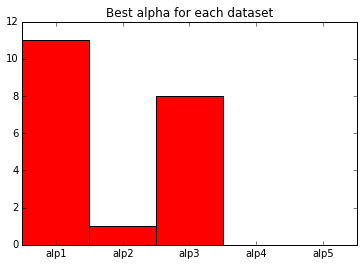

In [27]:
solve_logistic(nr_logistic, params1, normalize)

### Stochastic Gradient Ascent with raw data

###########################################################
Dataset: 0
Best alpha: 0.01


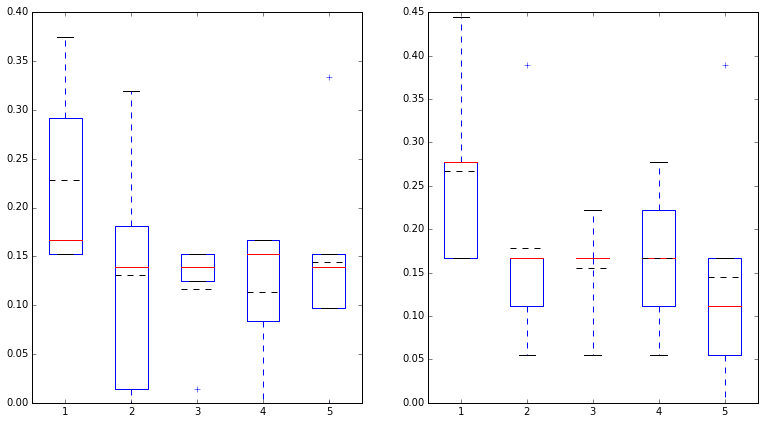

Training error rate: 0.122222222222
Testing error rate: 0.133333333333
N° iterations: 5597
Beta: [  -2.77201882    3.38715113   -3.35672344    0.29379831   72.6531521
 -189.58276094    0.38774768]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.01


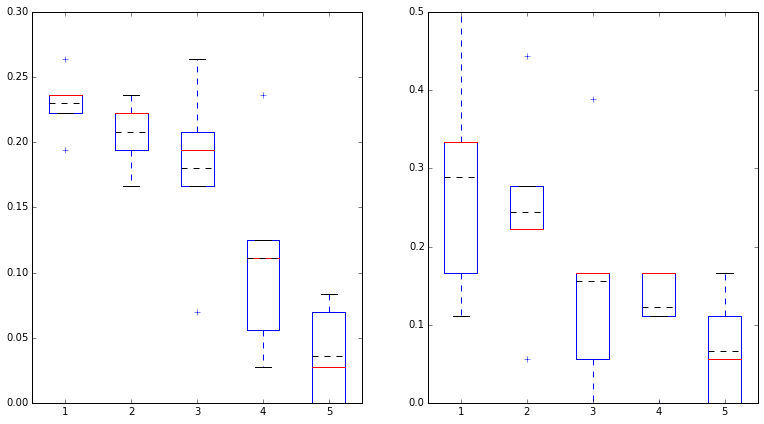

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 100000
Beta: [  2.96220868e+02   5.94310552e+00  -1.62573263e+01  -3.97416950e-01
   2.73784075e+02  -7.30271374e+02   3.56037168e+00]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.0055


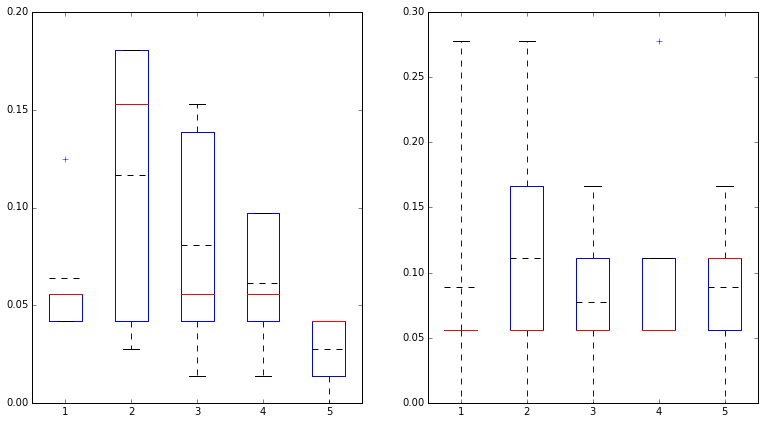

Training error rate: 0.1
Testing error rate: 0.233333333333
N° iterations: 1594
Beta: [  2.2635755    0.38709566  -2.57930402  -1.00174563  31.52178003
 -46.01375111   2.38068629]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.0055


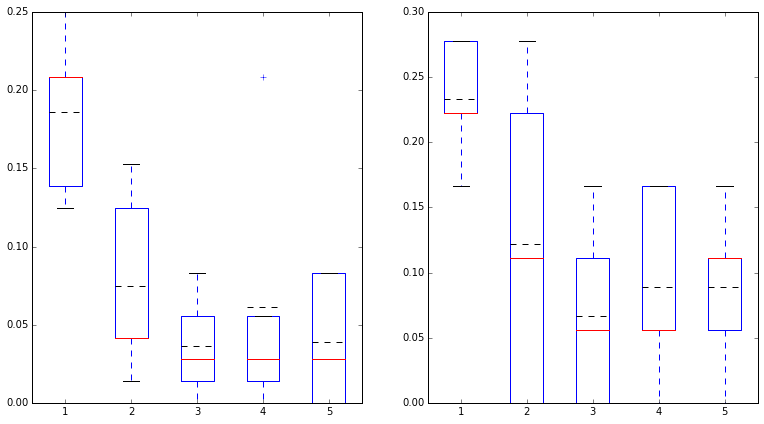

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 36061
Beta: [  31.69633403    3.14894115   -2.5040972    -0.36174921   74.64877034
 -238.25081696   -2.6841496 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.00775


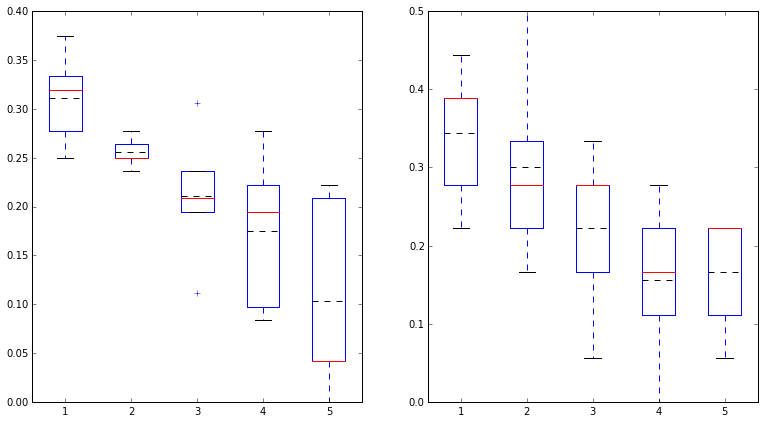

Training error rate: 0.0555555555556
Testing error rate: 0.0666666666667
N° iterations: 100000
Beta: [  5.50725896e+01   1.23452509e+01  -1.83093594e+01   6.56583251e-01
   2.71031080e+02  -7.13888691e+02   9.08417475e+00]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.01


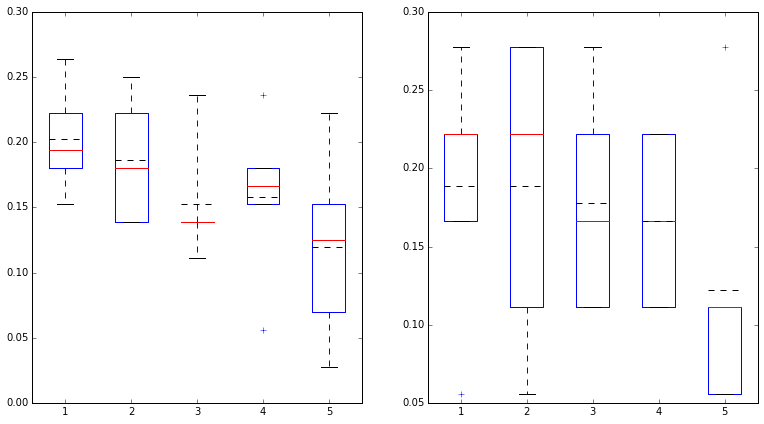

Training error rate: 0.0111111111111
Testing error rate: 0.0333333333333
N° iterations: 100000
Beta: [  1.98637878e+02   4.59190459e+00  -1.76701364e+01   1.13880414e-01
   2.12302462e+02  -4.96390153e+02   1.02183057e+01]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.00775


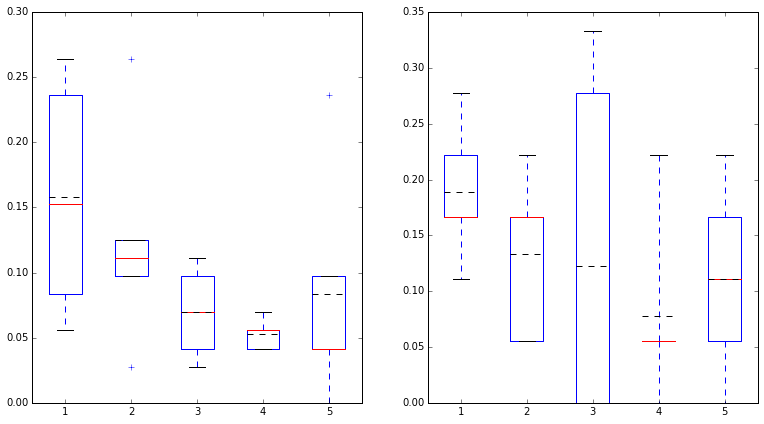

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 24426
Beta: [  66.28943327    2.62815811   -4.44461828   -0.31044347   83.28410451
 -251.7378331    -0.33811518]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.01


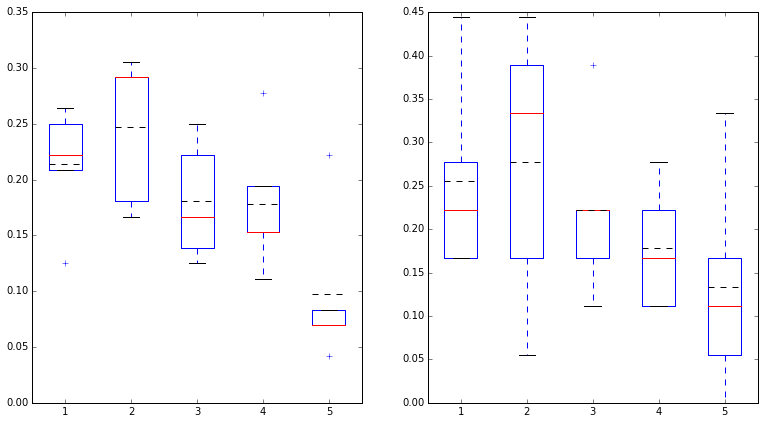

Training error rate: 0.1
Testing error rate: 0.0
N° iterations: 5517
Beta: [  15.86355057    2.61879208   -5.9958132    -0.96142963   82.8341468
 -204.74675816    4.3879038 ]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.01


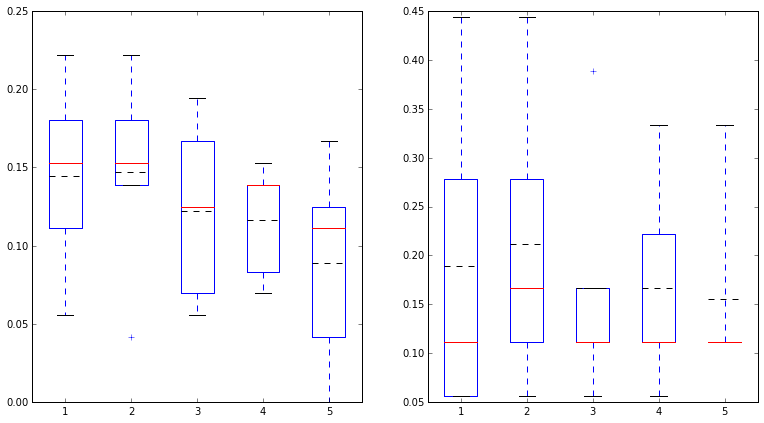

Training error rate: 0.0444444444444
Testing error rate: 0.1
N° iterations: 7437
Beta: [  15.82949665    2.33619918   -4.12898442   -0.27931539   81.40187178
 -248.93266015    3.48212139]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.01


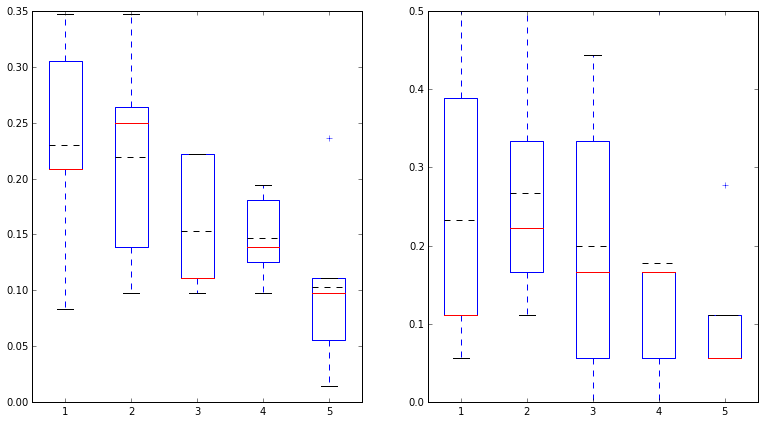

Training error rate: 0.0444444444444
Testing error rate: 0.0333333333333
N° iterations: 100000
Beta: [  6.47049595e+01   1.73374504e+01  -1.38824100e+01  -6.41161445e-01
   2.95320384e+02  -9.17307229e+02  -1.07515629e+00]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.00775


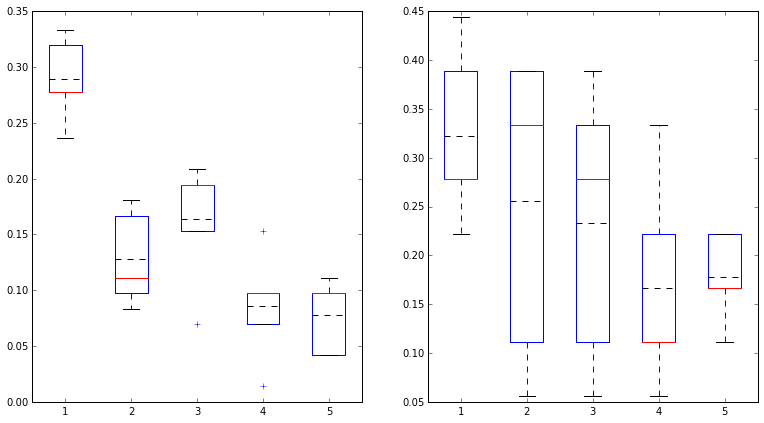

Training error rate: 0.0777777777778
Testing error rate: 0.0333333333333
N° iterations: 15573
Beta: [  34.19251485    4.32565401   -7.31939695   -0.65673664  101.94890151
 -240.34929982    3.18664288]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.00775


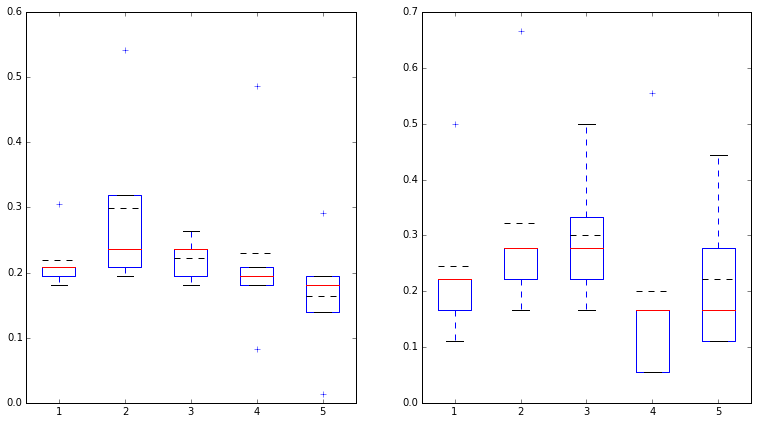

Training error rate: 0.188888888889
Testing error rate: 0.3
N° iterations: 8440
Beta: [   7.95196568    4.38307616   -2.05560182    1.33837748   59.56178386
 -198.48172868   -1.78307151]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.01


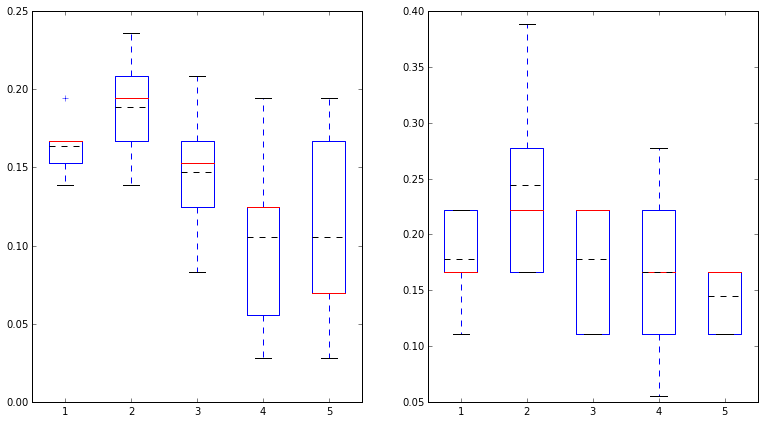

Training error rate: 0.0666666666667
Testing error rate: 0.0
N° iterations: 8075
Beta: [  37.28120688    4.77510427   -3.04491408   -0.55979802   93.73152904
 -295.60391698   -4.06865679]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.00775


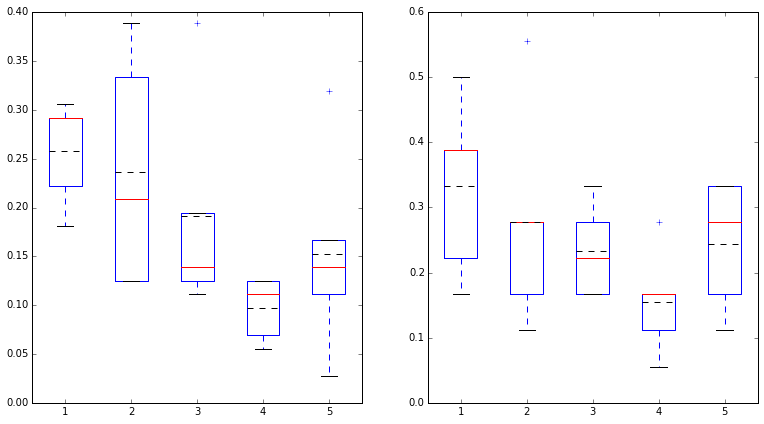

Training error rate: 0.1
Testing error rate: 0.1
N° iterations: 8295
Beta: [  16.72232918    2.14718009   -4.74198117   -1.39808779   80.07311116
 -206.35093256    2.50869161]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0055


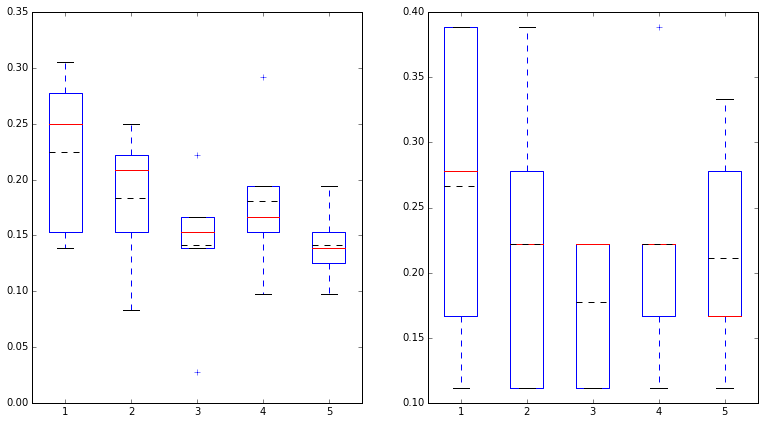

Training error rate: 0.166666666667
Testing error rate: 0.233333333333
N° iterations: 4379
Beta: [   5.53236866    1.99840753   -3.42166633    0.87815441   48.18881
 -115.00761954    2.59538129]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.01


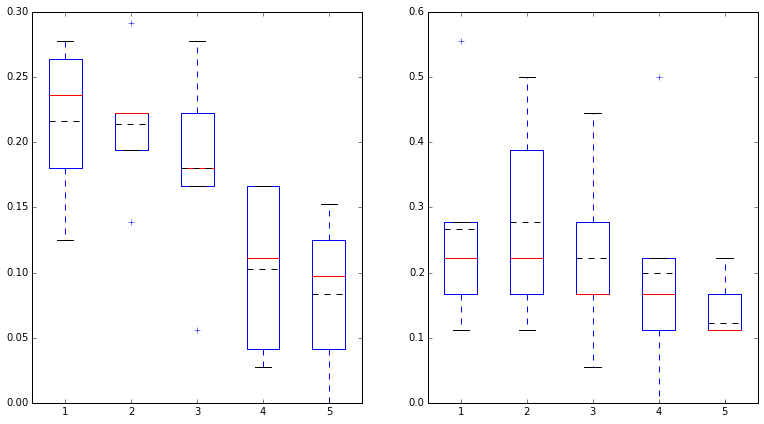

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 9090
Beta: [  4.81095935e+01   4.25893090e+00  -9.47334747e+00   5.62223680e-02
   1.19851884e+02  -3.25760262e+02   7.85554049e+00]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.01


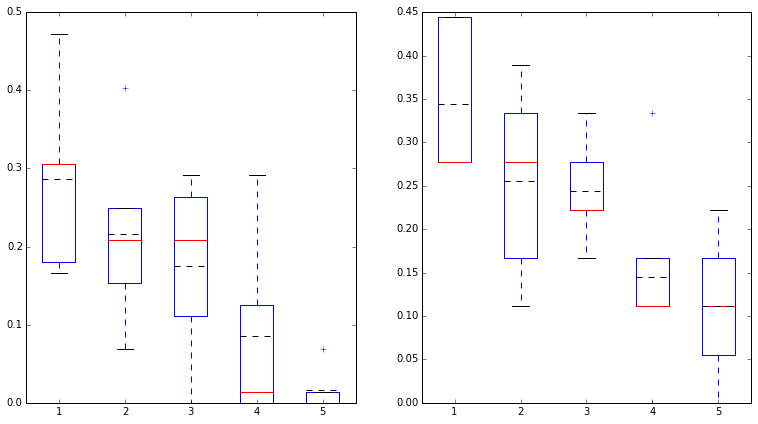

Training error rate: 0.0111111111111
Testing error rate: 0.133333333333
N° iterations: 100000
Beta: [ 119.26598541   15.5547044   -14.08948163   -1.26911806  298.08227115
 -740.97221574   -7.08799705]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.0055


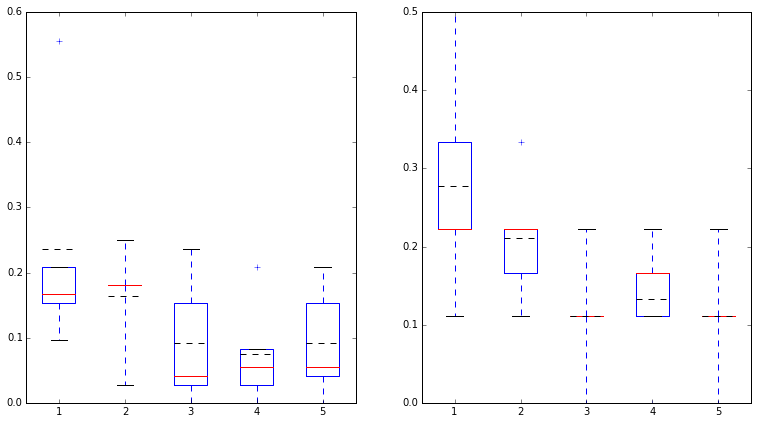

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 8505
Beta: [  1.41167539e+00   3.25496018e-01  -3.43224585e+00   8.04290874e-02
   5.53515028e+01  -1.25886642e+02   3.91139290e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.00775


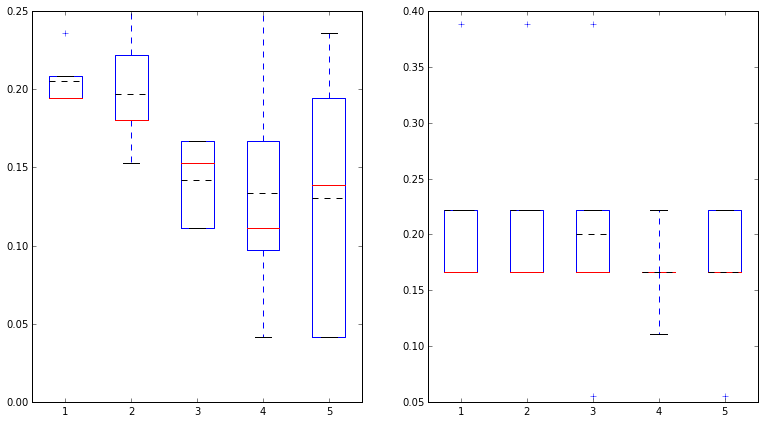

Training error rate: 0.111111111111
Testing error rate: 0.166666666667
N° iterations: 13747
Beta: [  21.87934726    4.98441172   -4.05983966    0.63331549  100.51241416
 -246.97168278   -5.14995137]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.01


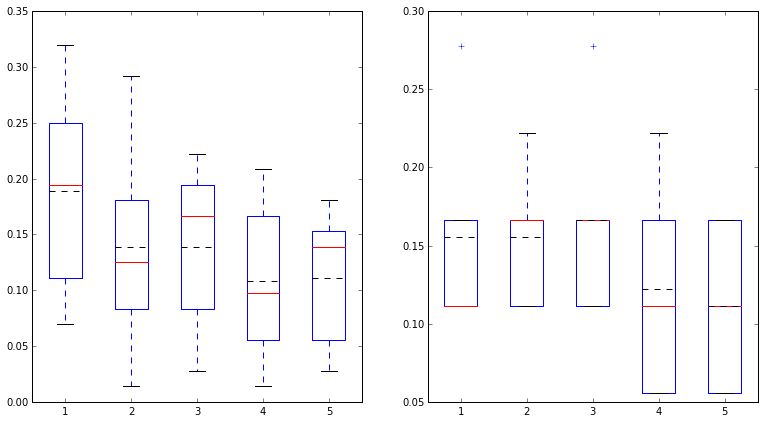

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 100000
Beta: [  3.00010214e+02   8.60435730e+00  -1.06446263e+01  -4.34057356e-01
   1.99552508e+02  -6.79706111e+02  -6.38398862e+00]
###########################################################




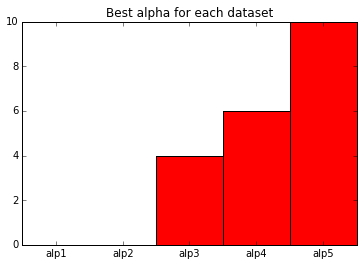

In [ ]:
solve_logistic(gd_stochastic, params2)

### Stochastic Gradient Ascent with rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.001


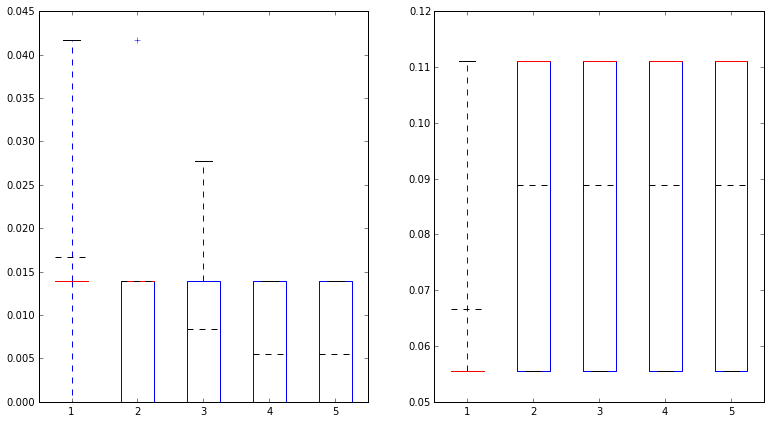

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 30094
Beta: [ -1.48226982   3.10845433  -6.56795702  -0.74596999  20.94421037
  -7.39747949   1.47998218]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


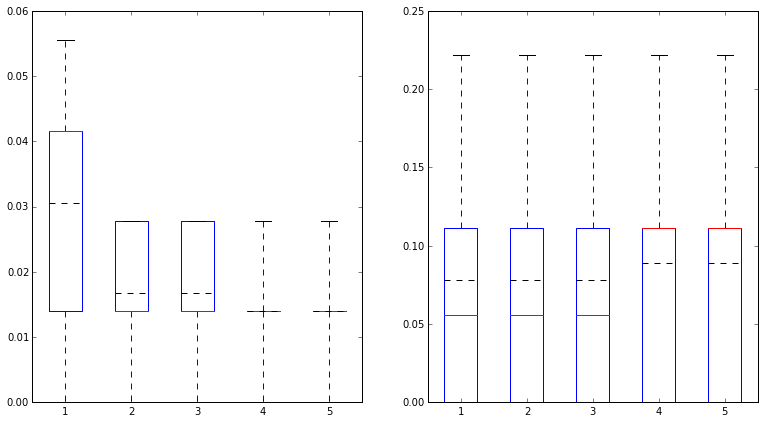

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 30362
Beta: [ -0.3350976    1.78285664  -7.54801788  -0.88024107  21.95851094
  -7.27964003   0.10261293]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


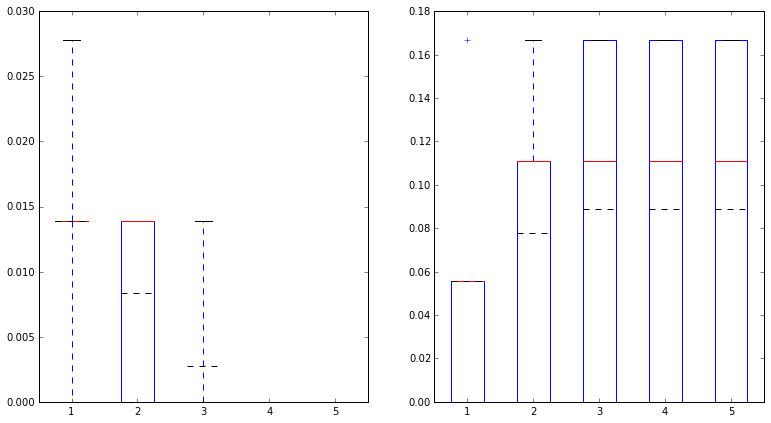

Training error rate: 0.0222222222222
Testing error rate: 0.266666666667
N° iterations: 33692
Beta: [ -0.18004134   2.51892629  -6.6083199   -2.02087147  20.2394211
  -9.31836999  -0.62494963]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.00325


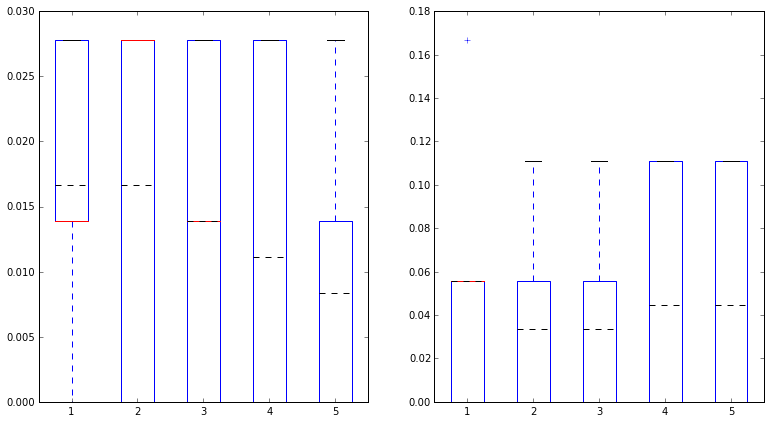

Training error rate: 0.0222222222222
Testing error rate: 0.2
N° iterations: 33377
Beta: [ -3.18546034   3.6573603  -10.44081432   1.40231312  33.94791137
 -11.32724045   3.9459928 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.00775


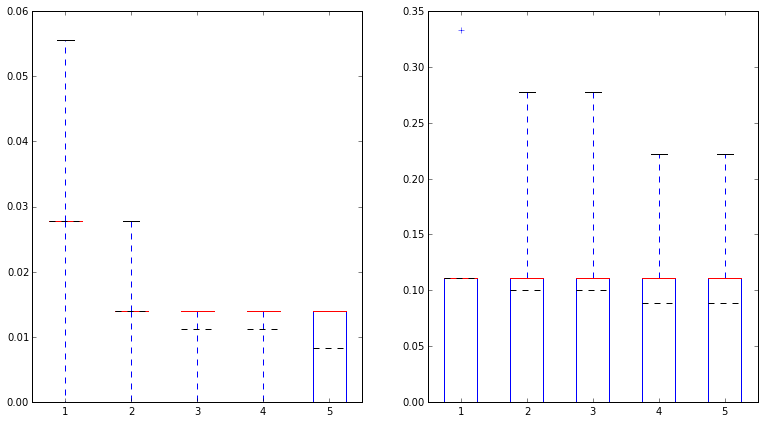

Training error rate: 0.0111111111111
Testing error rate: 0.0666666666667
N° iterations: 22589
Beta: [  1.37777031   2.92424144 -15.17935656  -2.77520176  39.89058245
 -13.26955394  -0.3819851 ]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.00325


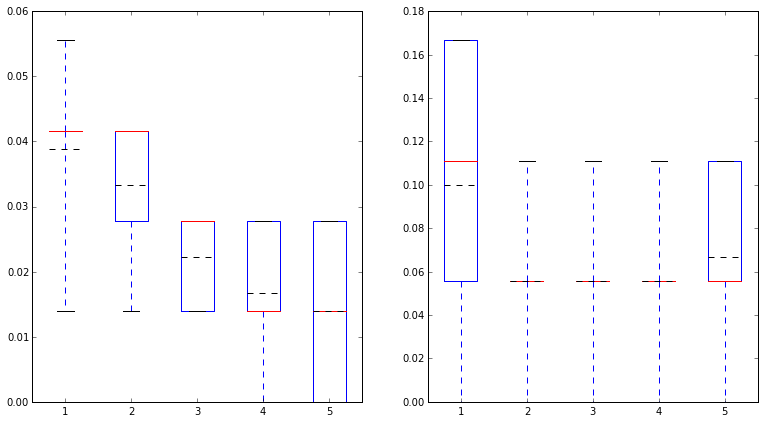

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 22923
Beta: [  0.24919718   2.277642   -11.05563371  -1.50702535  28.99501356
  -9.47242442   0.84556142]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.00325


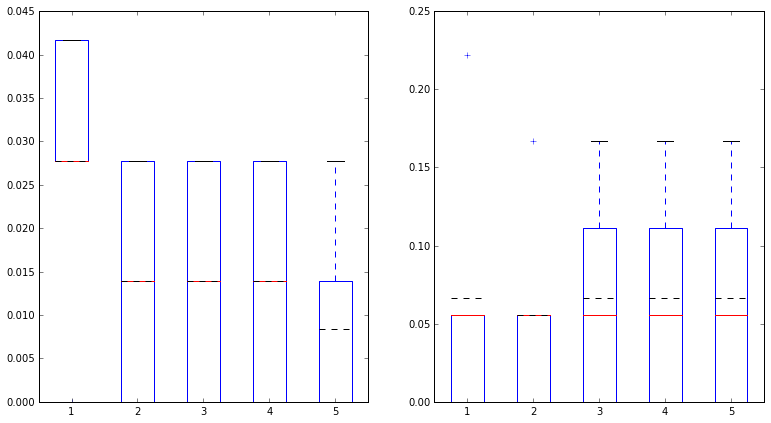

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 30493
Beta: [  2.75727723   0.27848703 -13.81133473  -2.4019636   29.99318716
 -11.43199973   0.09017219]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.0055


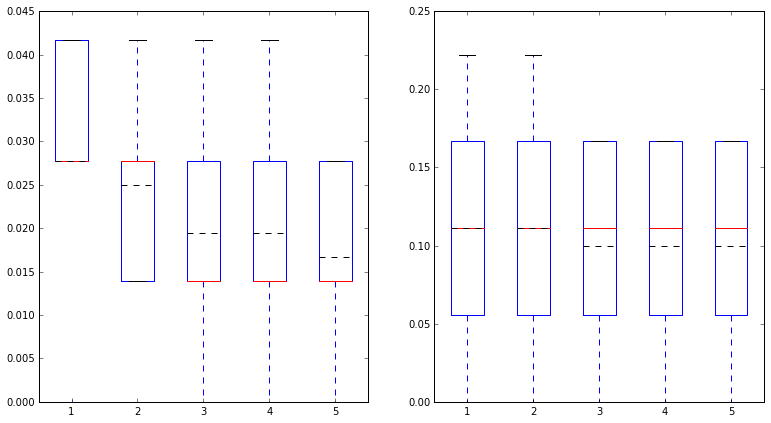

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 22254
Beta: [ -1.89327687   3.43563265 -12.83768893  -0.43677254  35.49873424
 -11.50203978   3.65426577]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.001


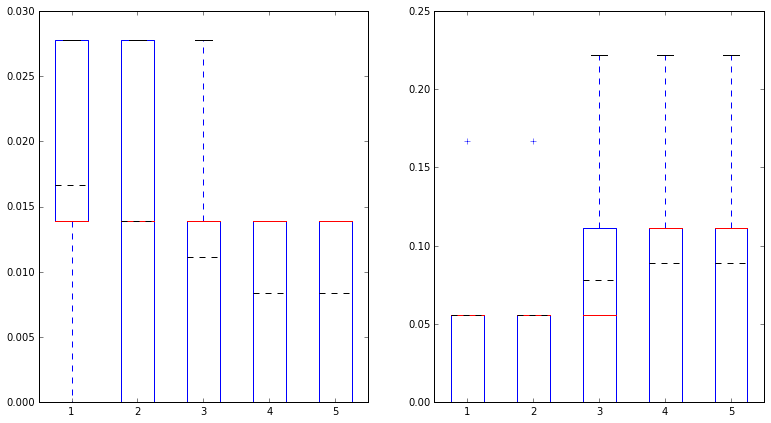

Training error rate: 0.0333333333333
Testing error rate: 0.0666666666667
N° iterations: 29501
Beta: [ -0.08223237   2.11576518  -7.58685974  -1.69763745  20.04931902
  -8.50629683   0.95290131]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.001


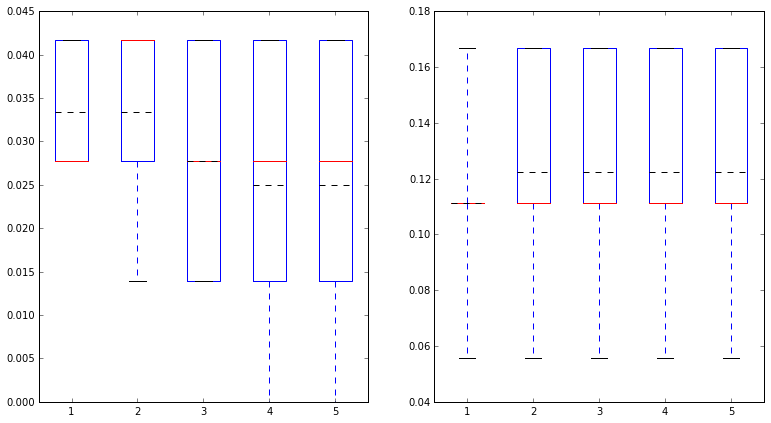

Training error rate: 0.0444444444444
Testing error rate: 0.166666666667
N° iterations: 24527
Beta: [ -1.27812323   3.22847512  -6.56031564  -1.08235434  19.51811434
  -6.58761284   0.65722461]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.001


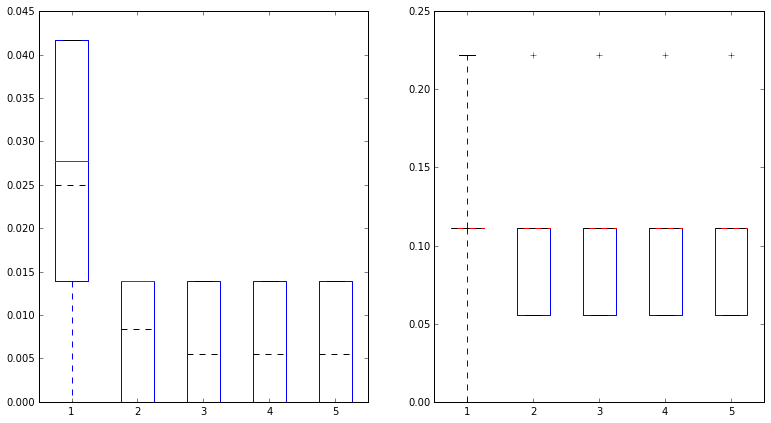

Training error rate: 0.0222222222222
Testing error rate: 0.1
N° iterations: 28419
Beta: [ -0.51948992   2.6048301   -8.26761878  -1.37442804  19.70238853
  -7.58313334   0.84540945]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.001


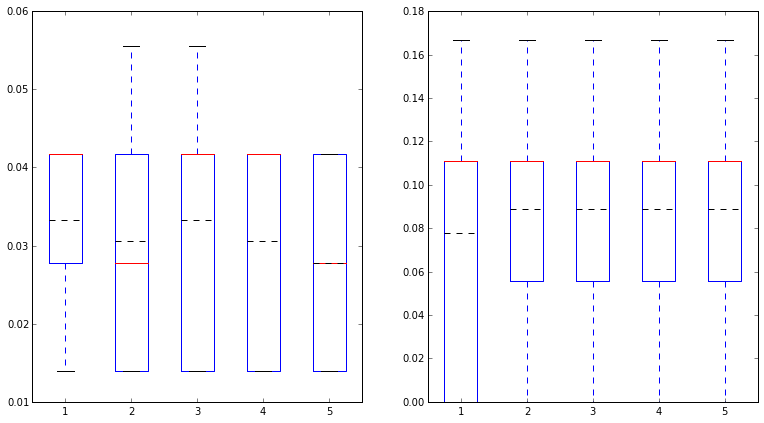

Training error rate: 0.0333333333333
Testing error rate: 0.133333333333
N° iterations: 26769
Beta: [ -1.10786796   2.33844479  -5.27238146  -0.12312292  20.34605662
  -7.47816117   0.75113069]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.001


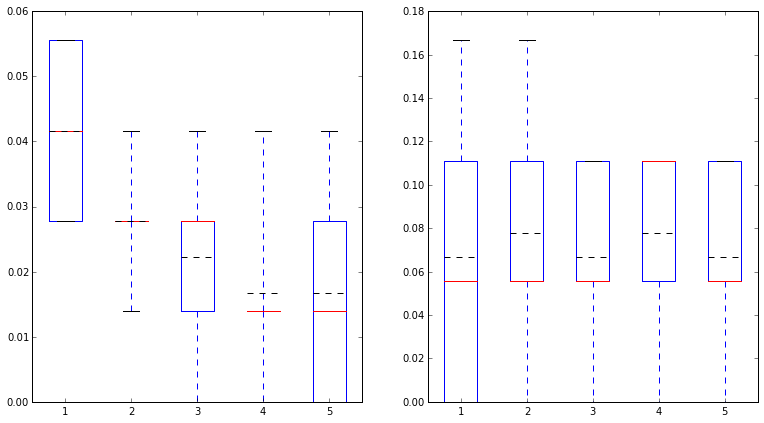

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 26266
Beta: [  0.15618017   1.93669698  -7.1142009   -0.77145274  19.45093159
  -7.03030324   0.71270764]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


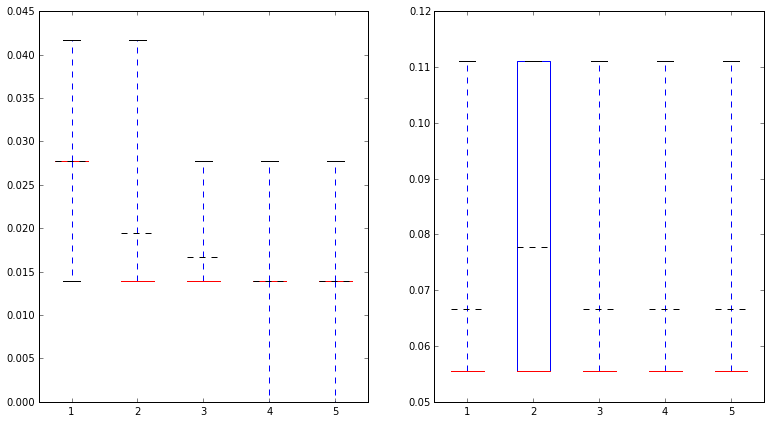

Training error rate: 0.0222222222222
Testing error rate: 0.0
N° iterations: 28551
Beta: [  0.7605753    1.66421907  -8.25068576  -1.86717674  19.96618115
  -7.07100621   0.0964316 ]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.001


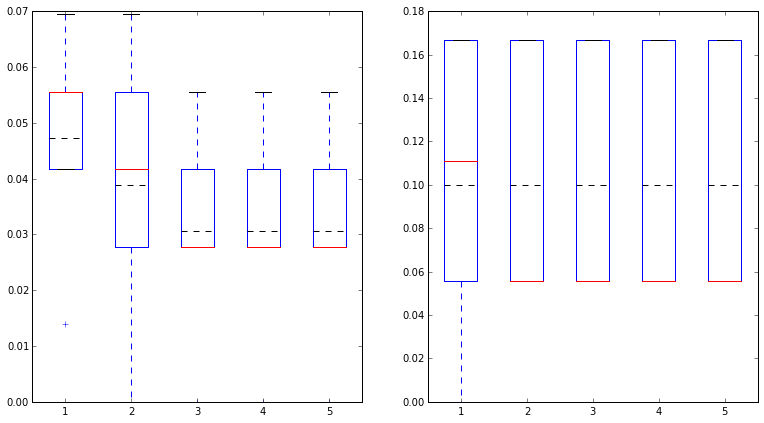

Training error rate: 0.0444444444444
Testing error rate: 0.166666666667
N° iterations: 25697
Beta: [ -1.42772421   3.50726093  -6.07024427  -1.06006468  20.35926098
  -6.98091889   0.2542705 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


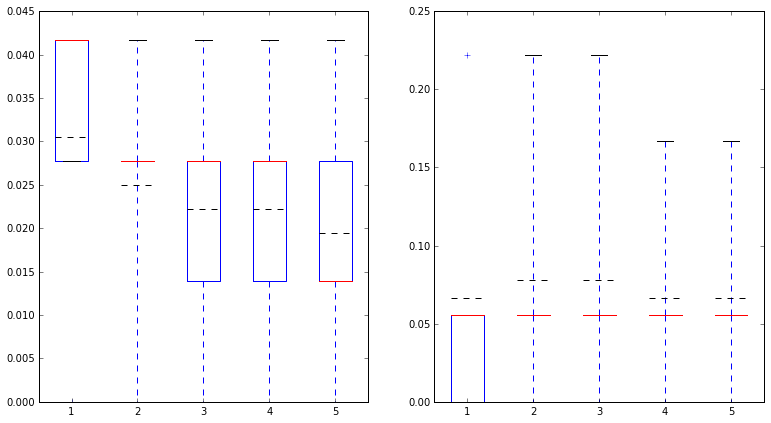

Training error rate: 0.0333333333333
Testing error rate: 0.166666666667
N° iterations: 27432
Beta: [  0.57046464   1.59463087  -7.43514893  -1.12446697  20.10535806
  -7.5073541    1.33498818]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


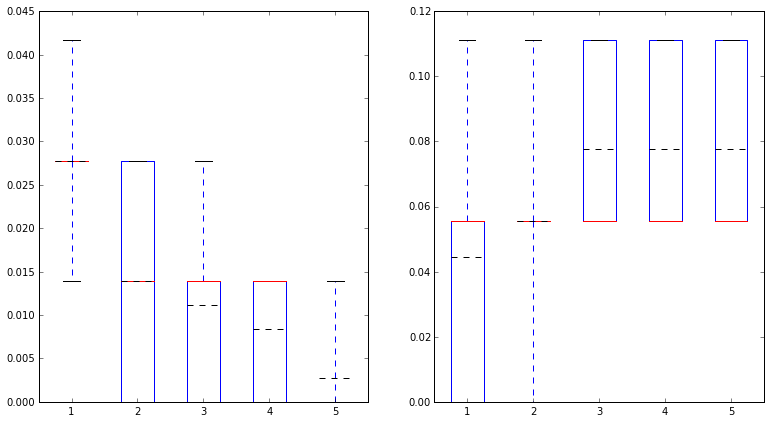

Training error rate: 0.0333333333333
Testing error rate: 0.2
N° iterations: 33010
Beta: [ -2.77940767   3.89934021  -5.64189862  -0.83647005  22.61962827
  -7.2236446    1.03948318]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.01


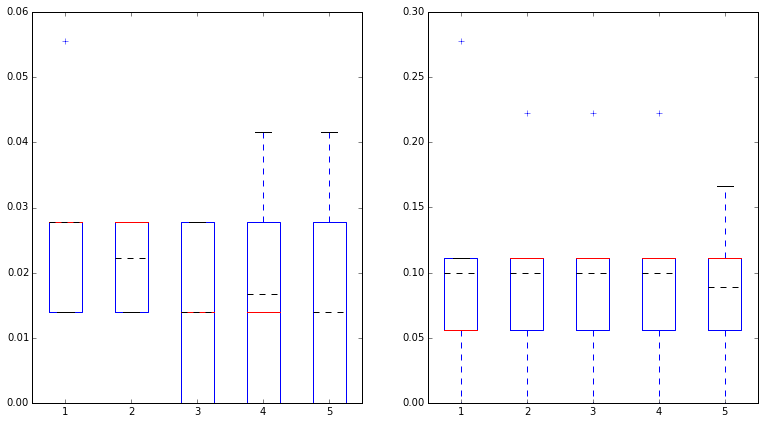

Training error rate: 0.0222222222222
Testing error rate: 0.166666666667
N° iterations: 22359
Beta: [  2.51850734   2.66217391 -16.82498501  -4.55875256  41.23397366
 -12.51769947  -3.720826  ]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


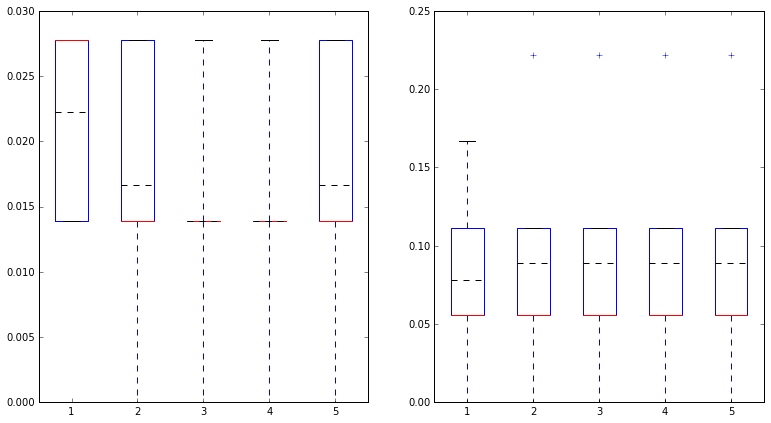

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 28333
Beta: [ -1.93638098   2.48464656  -4.92888944   0.1708657   20.42787817
  -7.23494195  -0.14271104]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.00325


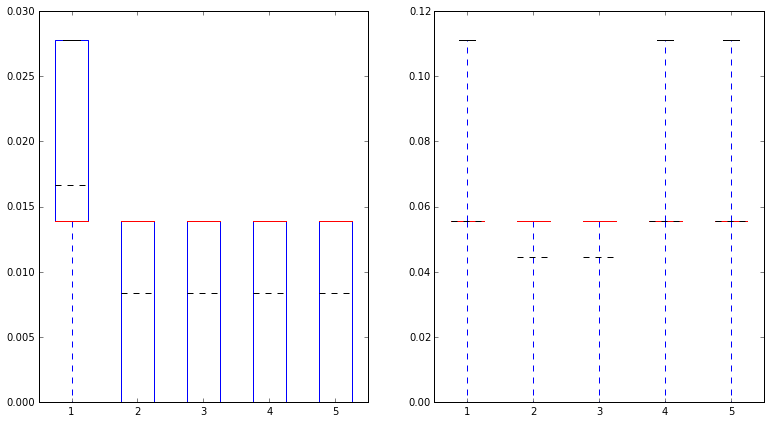

Training error rate: 0.0111111111111
Testing error rate: 0.166666666667
N° iterations: 27880
Beta: [  3.31790124   1.5579711  -12.09740063  -3.83640828  26.5917787
 -11.23145584  -1.83157801]
###########################################################




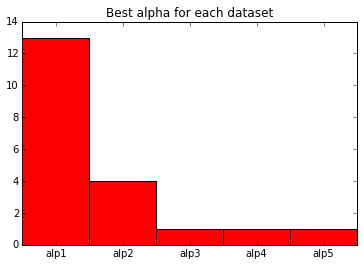

In [7]:
solve_logistic(gd_stochastic, params2, rescale)

### Stochastic Gradient Ascent with normalized data

###########################################################
Dataset: 0
Best alpha: 0.00325


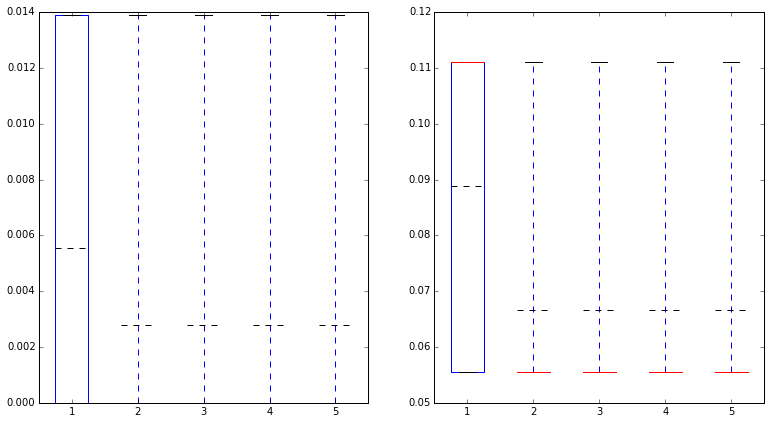

Training error rate: 0.0111111111111
Testing error rate: 0.0333333333333
N° iterations: 22853
Beta: [  0.28212691   2.51599989  -6.84871026  -2.01439963  17.09542325
 -11.65905654   0.02334595]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0055


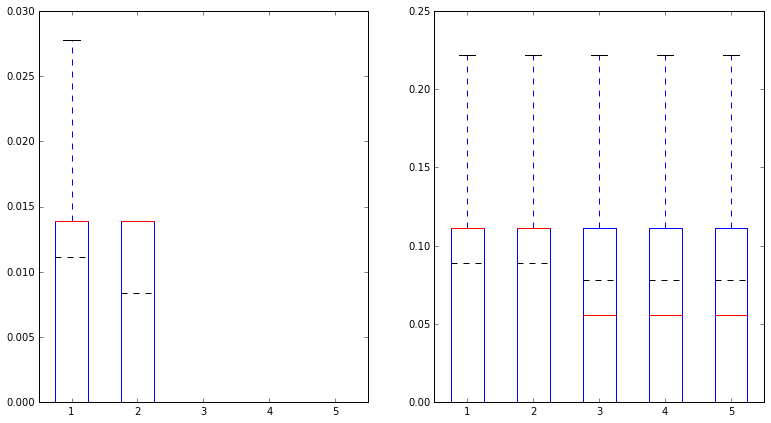

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 23074
Beta: [ -0.83064519  -0.04761609 -11.36013897  -3.3839981   20.45804098
 -13.26422916  -0.05551133]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


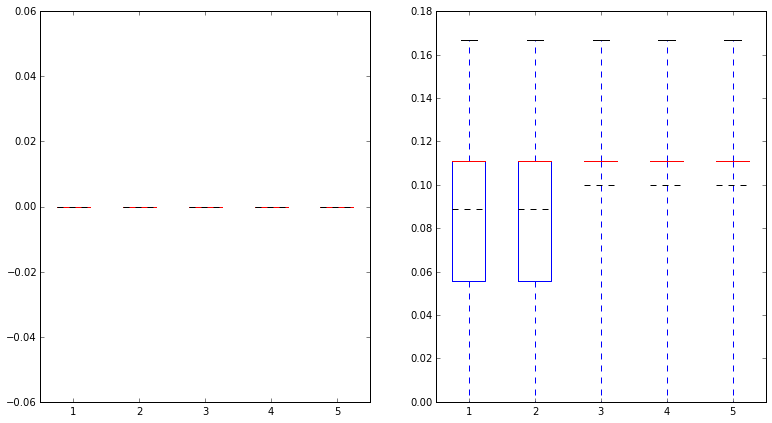

Training error rate: 0.0
Testing error rate: 0.1
N° iterations: 42727
Beta: [ -0.91044063   0.35160614  -6.42769225  -2.59085862  13.43806322
 -10.45973575  -0.50162077]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.001


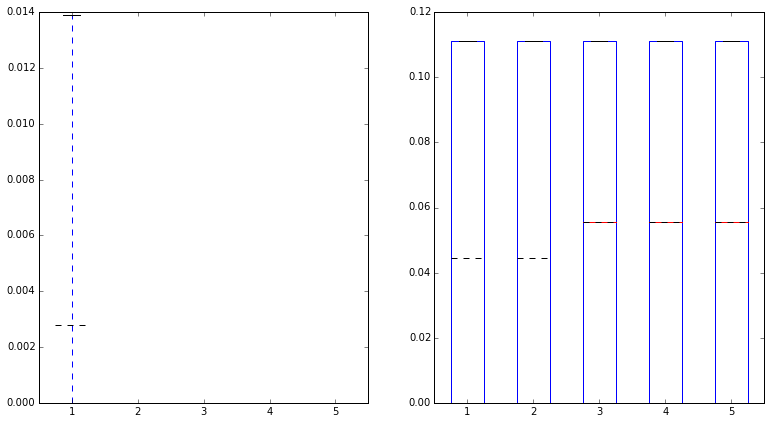

Training error rate: 0.0111111111111
Testing error rate: 0.0666666666667
N° iterations: 30368
Beta: [  0.76931706   1.2793493   -5.14824189   0.5091976   13.10813001
  -8.03395793   1.39673957]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.001


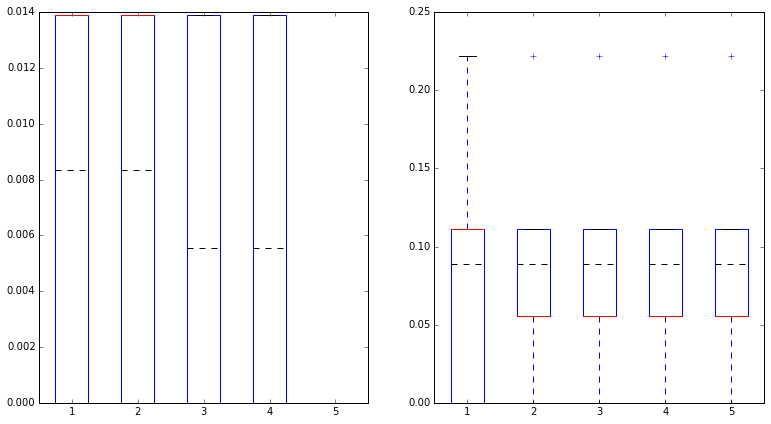

Training error rate: 0.0111111111111
Testing error rate: 0.166666666667
N° iterations: 21107
Beta: [ -1.68505952   0.82651988  -5.165582    -1.69058352  11.46118337
  -7.05492595  -0.27537794]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.001


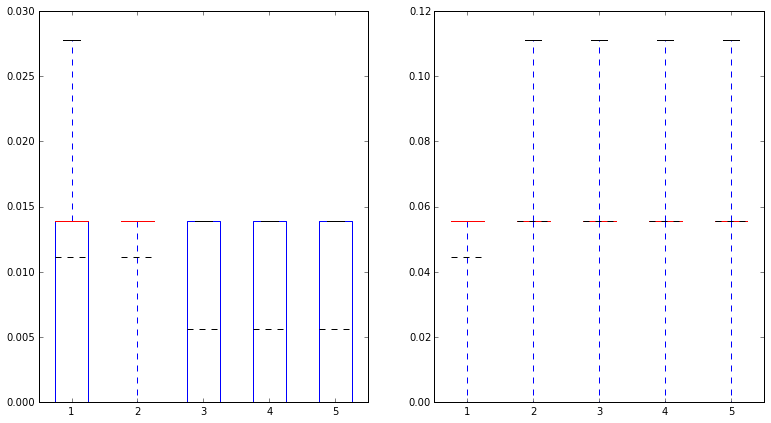

Training error rate: 0.0111111111111
Testing error rate: 0.0
N° iterations: 19506
Beta: [ -0.57658756   0.57391625  -5.22195648  -1.36432079  10.70644866
  -6.98938989   0.23329645]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.001


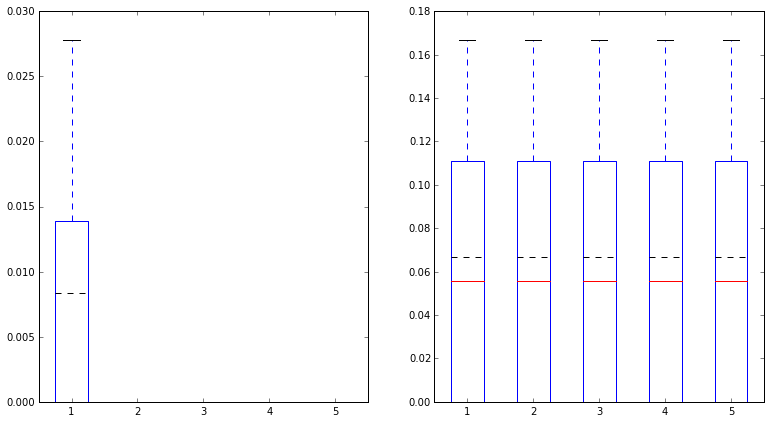

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 27785
Beta: [  0.25973306  -0.43656727  -6.84416509  -1.92523736  11.72510341
  -7.99440143  -0.04086211]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


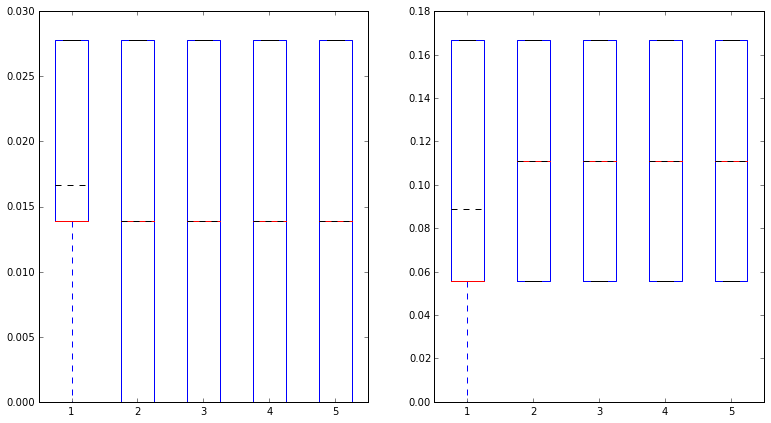

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 19145
Beta: [ -0.56486738   1.00875189  -5.04731249  -0.67516137  10.82344978
  -7.08214331   0.79262915]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.001


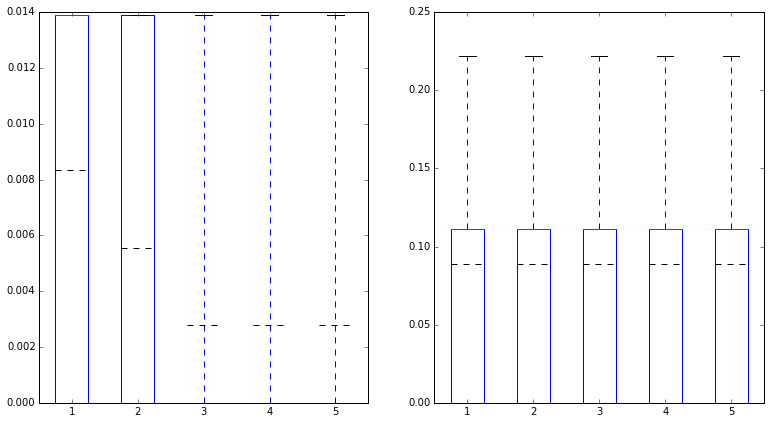

Training error rate: 0.0111111111111
Testing error rate: 0.1
N° iterations: 26466
Beta: [  0.98512574   0.20449691  -6.18565185  -2.61863488  11.52072476
  -8.55935312  -0.19801622]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.00325


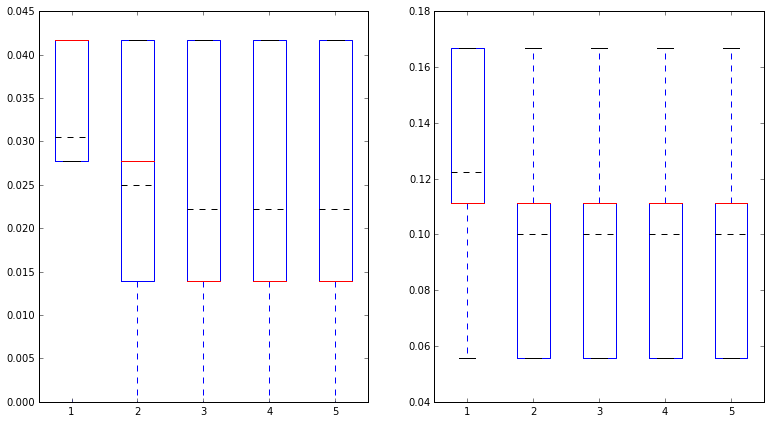

Training error rate: 0.0222222222222
Testing error rate: 0.0666666666667
N° iterations: 13573
Beta: [  1.18086384   1.29180006  -6.2545281   -2.19180191  14.36792718
  -8.8891139   -0.10662136]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.00325


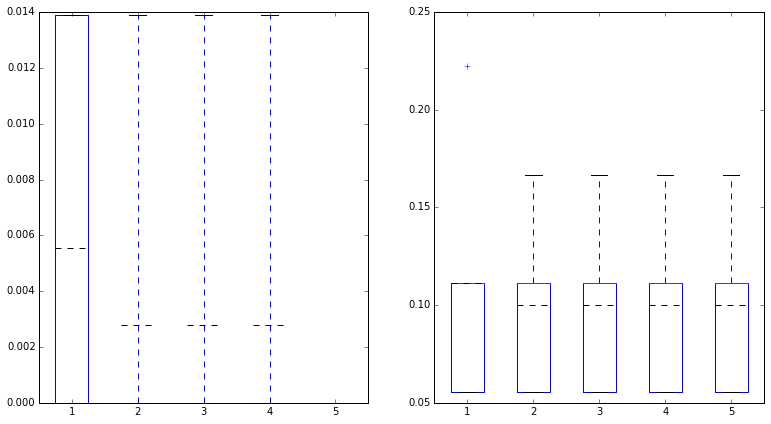

Training error rate: 0.0111111111111
Testing error rate: 0.0333333333333
N° iterations: 28782
Beta: [ -0.40754412   0.89381136 -10.62162837  -4.14514186  19.02255444
 -11.92779315  -0.57515176]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.00325


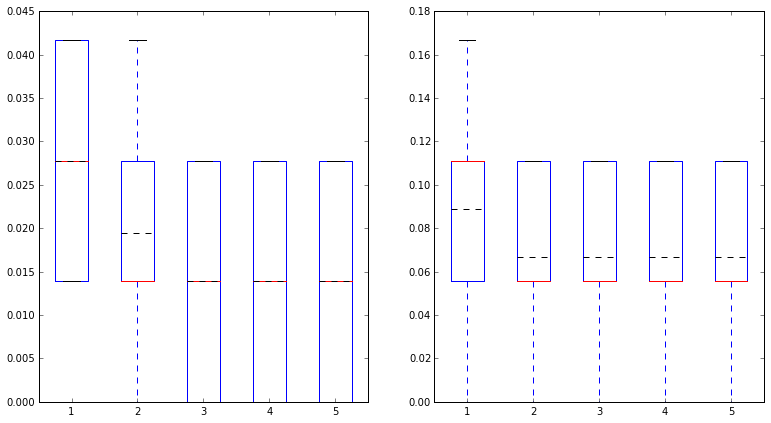

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 12480
Beta: [ -0.9140267    1.29982383  -5.61017373  -1.72271309  11.92047332
  -9.02566211  -0.60104034]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0055


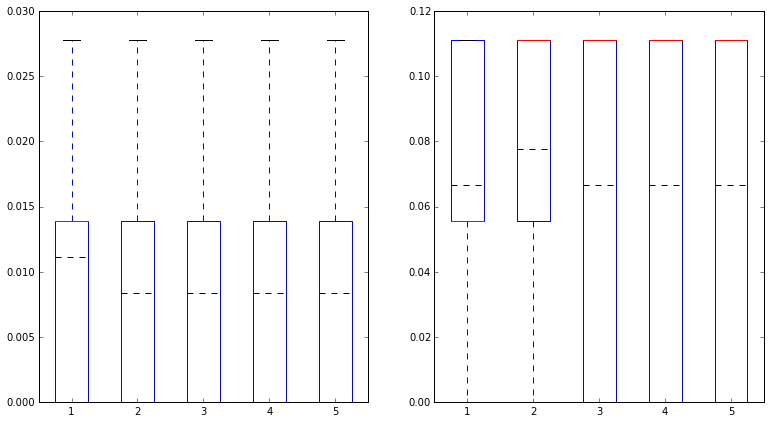

Training error rate: 0.0222222222222
Testing error rate: 0.0333333333333
N° iterations: 21089
Beta: [  1.17501047   1.25021376 -10.52537946  -4.79187833  20.17626635
 -13.03576152  -2.04678605]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


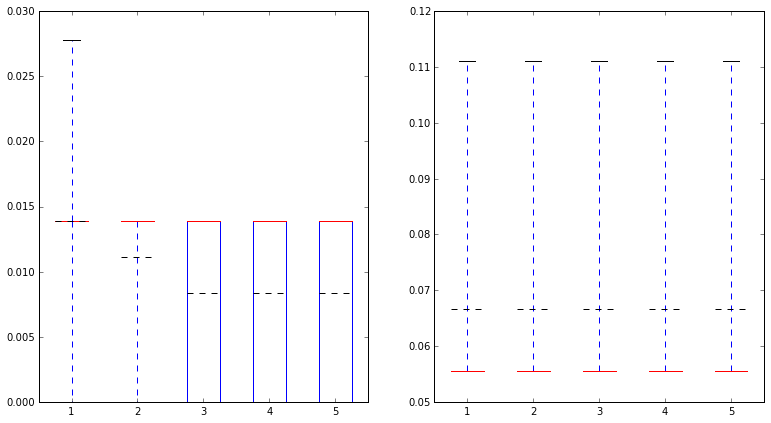

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 19371
Beta: [-0.83157681 -0.22984747 -6.32680414 -2.41278289  9.81267399 -6.74299817
 -0.35219639]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0055


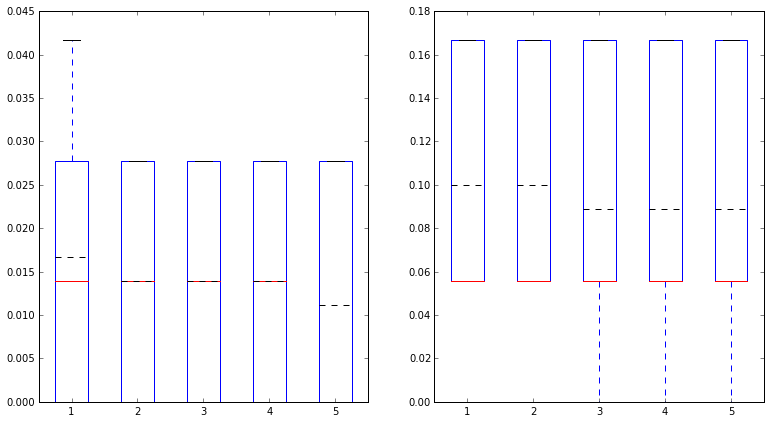

Training error rate: 0.0111111111111
Testing error rate: 0.0333333333333
N° iterations: 12311
Beta: [  1.06846176   1.51230049  -7.746944    -2.52735609  16.54763725
 -10.51471904  -0.15137984]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


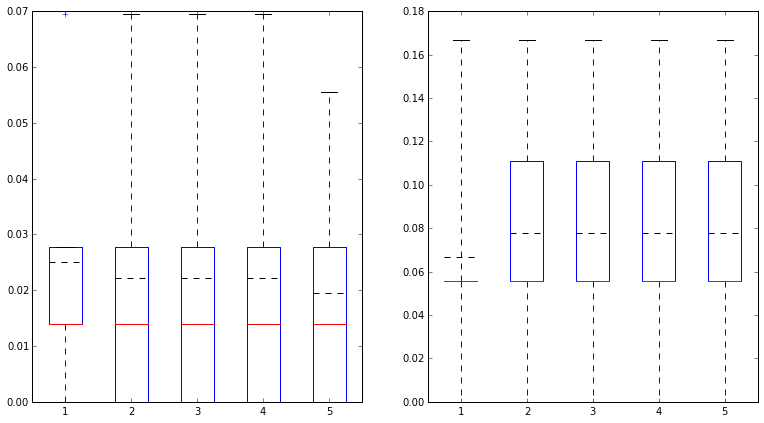

Training error rate: 0.0444444444444
Testing error rate: 0.0666666666667
N° iterations: 17110
Beta: [ 0.59735747  0.3925426  -4.97515802 -1.49478748  9.4856989  -7.05047378
  0.26428835]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


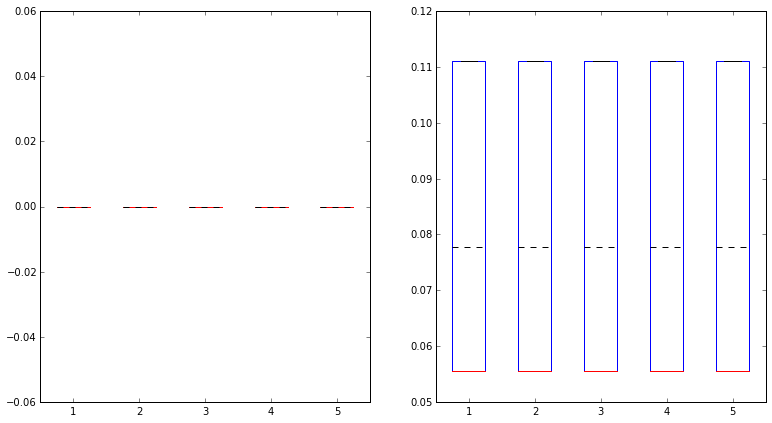

Training error rate: 0.0111111111111
Testing error rate: 0.166666666667
N° iterations: 32435
Beta: [  0.53147909   1.63587046  -5.40451023  -2.65320364  13.0548019
  -7.36149183  -0.71556737]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.001


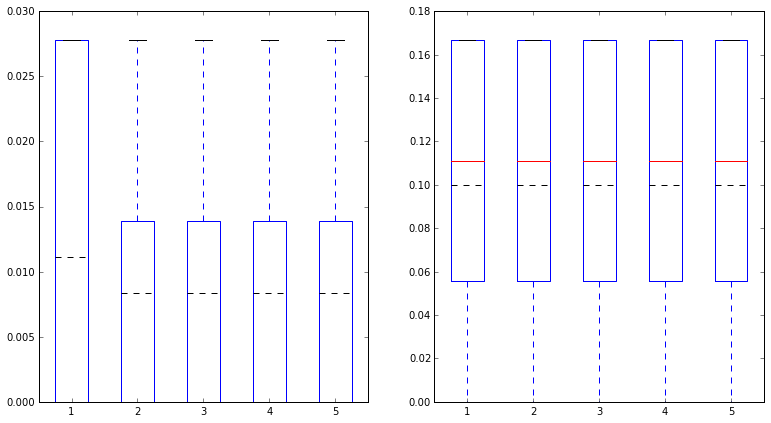

Training error rate: 0.0222222222222
Testing error rate: 0.133333333333
N° iterations: 20752
Beta: [  0.36508413   0.64407219  -5.21690358  -2.25339424  10.55314001
  -6.35046728  -1.08978961]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.0055


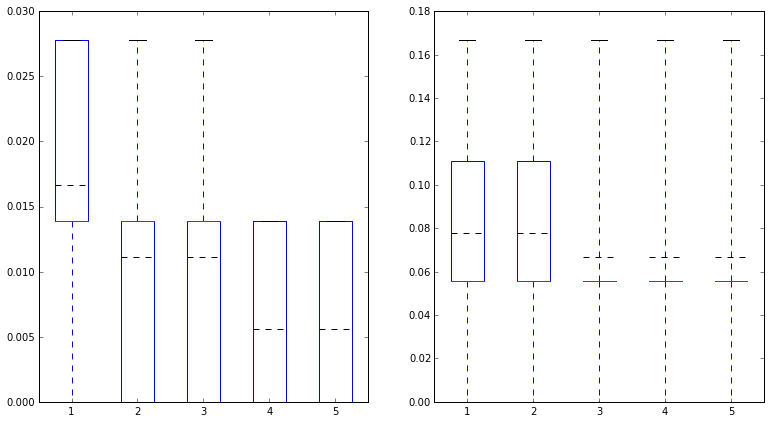

Training error rate: 0.0111111111111
Testing error rate: 0.0333333333333
N° iterations: 15138
Beta: [ -0.19324157   0.95201026  -6.27984075  -0.97020184  16.59249189
 -10.7422816   -1.27091608]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.00325


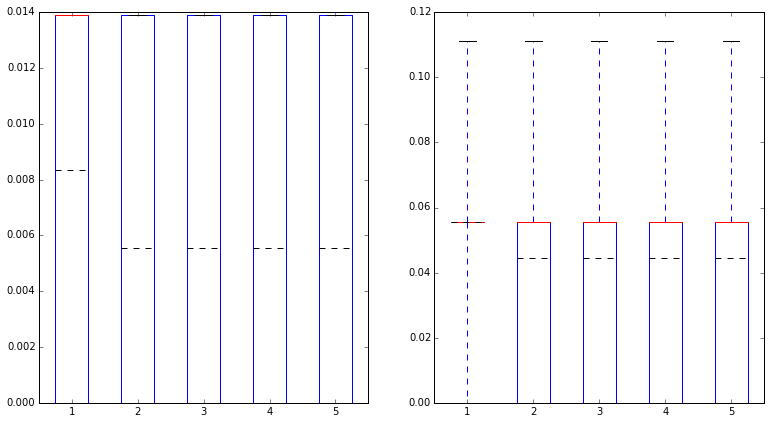

Training error rate: 0.0111111111111
Testing error rate: 0.133333333333
N° iterations: 18115
Beta: [ -1.21269386   0.43705506  -7.33098098  -3.21728362  13.02148325
  -9.7774349   -0.67099967]
###########################################################




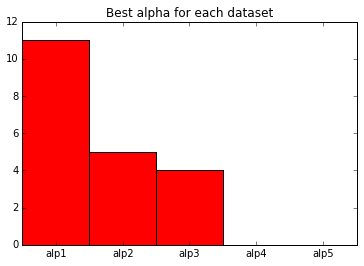

In [8]:
solve_logistic(gd_stochastic, params2, normalize)

In [89]:
#Newton-Raphson method for logistic regression
def nr_logistic(X, y, alpha, eps=1e-10, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in xrange(max_iter):
        l0 = l1
        h = sigmoid(np.dot(X,beta))
        #print 'beta:',beta
        print 'l:',l1
        #print 'h:',np.max(h)
        W = np.diag(h*(1-h))
        Hess = -1.*np.dot(X.T, np.dot(W, X))
        Dl = np.dot(X.T, y-h)
        #when it converges, Hess became singular
        try:
            beta -= alpha*np.linalg.solve(Hess, Dl)
        except np.linalg.LinAlgError:
            print 'singular'
            break
        l1 = l(X, y, beta)
        if np.abs(l1) < eps:
            print 'stopping criterion'
            break
    print 'l:',l1
    print 'h',h*(1-h)
    return (beta,i+1)